In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm import tqdm
import random
import os
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
import gc
from sklearn import preprocessing
from sklearn import metrics
from sklearn.model_selection import GroupKFold
import lightgbm as lgb
import tensorflow as tf

# Comentarios

Para graficar utilizaremos solo seaborn y matplotlib porque son ligeras y rapidas. Tambien podriamos usar bokeh, plotly, altair etc... Pero en mi experiencia esta se demoran mas para bases de datos de porte medianas grandes

Dejo mi perfil de kaggle, en esta plataforma tengo trabajos bastantes mas elaborados que este: https://www.kaggle.com/ragnar123

Para correr este script utilize mi laptop local, inteli7 generacion 8, 16gb ram

# Descripcion del problem


En este desafio se nos pide estimar la desviacion de los costos marginales en distintos nodos del sistema, con el objetivo de garantizar la operación más económica del sistema, preservar su seguridad y garantizar el acceso abierto a los sistemas de transimisón

# Algunas definiciones importantes:

Sistema Eléctrico: Conjunto de instalaciones de centrales eléctricas generadoras, líneas de transporte, subestaciones eléctricas, líneas de distribución, interconectadas entre sí, que permite generar, transportar y distribuir energía eléctrica.

Subestación: Conjunto de instalaciones eléctricas (transformadores, aisladores, interruptores, etc) y de infraestructura (terreno, edificio, etc), que sirven para transferir energía, transformar voltajes, recibir y entregar energía y suministrar electricidad a consumos.

Barra Principal: Es un tramo de conductores aislados, donde convergen líneas de transmisión, alimentación a bancos de autotransformadores y transformadores de poder que retiran o inyectan energía a la barra, permitiendo el traspaso de flujos de potencias entre las líneas. Si tienes dudas, puedes consultar el glosario del SIC (Sistema Interconectado Central) en https://sic.coordinador.cl/wp-content/uploads/2013/12/MP_Glosario_CDEC-SIC.pdf

# Features (Variables Independientes)

* nemotecnico_se: código subestación eléctrica

* fecha, hora: año, mes, día y hora.

* gen_eolica_total_mwh: generación eólica total por subestación en MWh

* gen_geotermica_total_mwh: generación geotérmica total por subestación en MWh

* gen_hidraulica_total_mwh: generación hidráulica total por subestación en MWh

* gen_solar_total_mwh: generación solar total por subestación en MWh

* gen_termica_total_mwh: generación térmica total por subestación en MWh

* cmg_real: costo marginal real [USD/MWh] promedio por subestación

* cmg_prog: costo marginal programado [USD/MWh] promedio por subestación

* cmg_desv: desviación absoluta promedio entre costo marginal programado y costo marginal real

* cmg_desv_pct: desviación porcentual promedio del costo marginal real con respecto al costo marginal programado

* n_barras: número de barras conectadas aguas abajo de una subestación

* demanda_mwh: retiros de energía [MWh] efectuados por compañías coordinadas bajo el sistema eléctrico

* cap_inst_mw: capacidad de generación máxima instalada por subestación [MW]

# 1.0 Costos Marginales

In [2]:
# Funcion para cargar .csv
def read_dataset(path, name):
    df = pd.read_csv(path)
    df_dim1, df_dim2 = df.shape[0], df.shape[1]
    print(f'Nuestro dataset {name} tiene {df_dim1} filas y {df_dim2} columnas')
    df = df.drop_duplicates()
    df_dim1, df_dim2 = df.shape[0], df.shape[1]
    print(f'Nuestro dataset {name} tiene {df_dim1} filas y {df_dim2} columnas despues de eliminar las filas duplicadas')
    return df

# Cargamos el archivo costo_marginal_real.csv
cmr = read_dataset('costo_marginal_real.csv', 'costo marginal real')
cmr.head()

Nuestro dataset costo marginal real tiene 4309951 filas y 7 columnas
Nuestro dataset costo marginal real tiene 4309951 filas y 7 columnas despues de eliminar las filas duplicadas


,barra_mnemotecnico,barra_referencia_mnemotecnico,fecha,hora,costo_en_dolares,costo_en_pesos,nombre
0,BA01T005SE075T005,BA02T002SE032T002,2019-04-06,25,62.24,41.47176,BA S/E LORETO 15KV
1,BA01T005SE175T005,BA02T002SE032T002,2019-04-06,25,62.56,41.68498,BA S/E RETIRO 13.2KV
2,BA03R002SE002R002,BA02T002SE032T002,2019-04-06,25,60.04,40.00585,BA S/E ALTAMIRANO 12.5KV BP1
3,BA01R002SE012R002,BA02T002SE032T002,2019-04-06,25,61.65,41.07863,BA S/E CURACAVI 44KV B1
4,BA03R002SE013R002,BA02T002SE032T002,2019-04-06,25,59.55,39.67936,BA S/E EL MANZANO (ENEL DISTRIBUCIÓN) 23KV BP1


In [3]:
# Cargamos el archivo costo_marginal_programado.csv
cmp = read_dataset('costo_marginal_programado.csv', 'costo marginal programado')
cmp.head()

Nuestro dataset costo marginal programado tiene 1192124 filas y 5 columnas
Nuestro dataset costo marginal programado tiene 1187841 filas y 5 columnas despues de eliminar las filas duplicadas


,mnemotecnico_barra,nombre_barra,fecha,hora,costo
0,BA01T002SE002T002,BA S/E ALTO JAHUEL 110KV SECCION 1,2019-01-01,1,49.897334
1,BA01T002SE002T002,BA S/E ALTO JAHUEL 110KV SECCION 1,2019-01-01,2,50.471616
2,BA01T002SE002T002,BA S/E ALTO JAHUEL 110KV SECCION 1,2019-01-01,3,50.077821
3,BA01T002SE002T002,BA S/E ALTO JAHUEL 110KV SECCION 1,2019-01-01,4,49.796216
4,BA01T002SE002T002,BA S/E ALTO JAHUEL 110KV SECCION 1,2019-01-01,5,49.796216


* Los archivos anteriores no tienen la misma cantidad de registros
* Se puede observar que el archivo costo marginal programado tiene filas duplicadas

Habran mas datos duplicados en esta base?

In [4]:
cmp.drop_duplicates(['mnemotecnico_barra', 'fecha', 'hora', 'nombre_barra']).shape

(1003895, 5)

Efectivamente existen barras exactamente iguales pero con distintos costos, promediemos estos registros dado que no sabemos cual es el correcto (por ahora)

In [5]:
cmp = cmp.groupby(['mnemotecnico_barra', 'fecha', 'hora', 'nombre_barra'])['costo'].mean().reset_index()

In [6]:
# Realizamos un merge entre las dos bases anteriores (left join para no perder informacion)
costo_marginal = cmr.merge(cmp, 
                           how = 'left',
                           left_on = ['barra_mnemotecnico', 'fecha', 'hora', 'nombre'], 
                           right_on = ['mnemotecnico_barra', 'fecha', 'hora', 'nombre_barra'])
dim1, dim2 = costo_marginal.shape[0], costo_marginal.shape[1]
print(f'Nuestra nueva base tiene {dim1} filas y {dim2} columnas')
# Veamos si existen datos duplicados
costo_marginal = costo_marginal.drop_duplicates()
dim1, dim2 = costo_marginal.shape[0], costo_marginal.shape[1]
print(f'Nuestra nueva base despues de filtrar los duplicados tiene {dim1} filas y {dim2} columnas')
costo_marginal.head()

Nuestra nueva base tiene 4309951 filas y 10 columnas
Nuestra nueva base despues de filtrar los duplicados tiene 4309951 filas y 10 columnas


,barra_mnemotecnico,barra_referencia_mnemotecnico,fecha,hora,costo_en_dolares,costo_en_pesos,nombre,mnemotecnico_barra,nombre_barra,costo
0,BA01T005SE075T005,BA02T002SE032T002,2019-04-06,25,62.24,41.47176,BA S/E LORETO 15KV,NaN,NaN,NaN
1,BA01T005SE175T005,BA02T002SE032T002,2019-04-06,25,62.56,41.68498,BA S/E RETIRO 13.2KV,NaN,NaN,NaN
2,BA03R002SE002R002,BA02T002SE032T002,2019-04-06,25,60.04,40.00585,BA S/E ALTAMIRANO 12.5KV BP1,NaN,NaN,NaN
3,BA01R002SE012R002,BA02T002SE032T002,2019-04-06,25,61.65,41.07863,BA S/E CURACAVI 44KV B1,NaN,NaN,NaN
4,BA03R002SE013R002,BA02T002SE032T002,2019-04-06,25,59.55,39.67936,BA S/E EL MANZANO (ENEL DISTRIBUCIÓN) 23KV BP1,NaN,NaN,NaN


Descartamos los datos duplicados, de hecho existen algunas columnas que podemos eliminar dado que ya tenemos sus registros contenidos en otra columna

In [7]:
costo_marginal.drop(['mnemotecnico_barra', 'nombre_barra'], axis = 1, inplace = True)

Relizemos un analisis para las variables resultantes

# Barra_mnemotecnico,  Barra_referencia_mnemotecnico & Nombre

Se analiza la columna barra_mnemotecnico
Existen 1020 datos unicos en nuestro columna barra_mnemotecnico


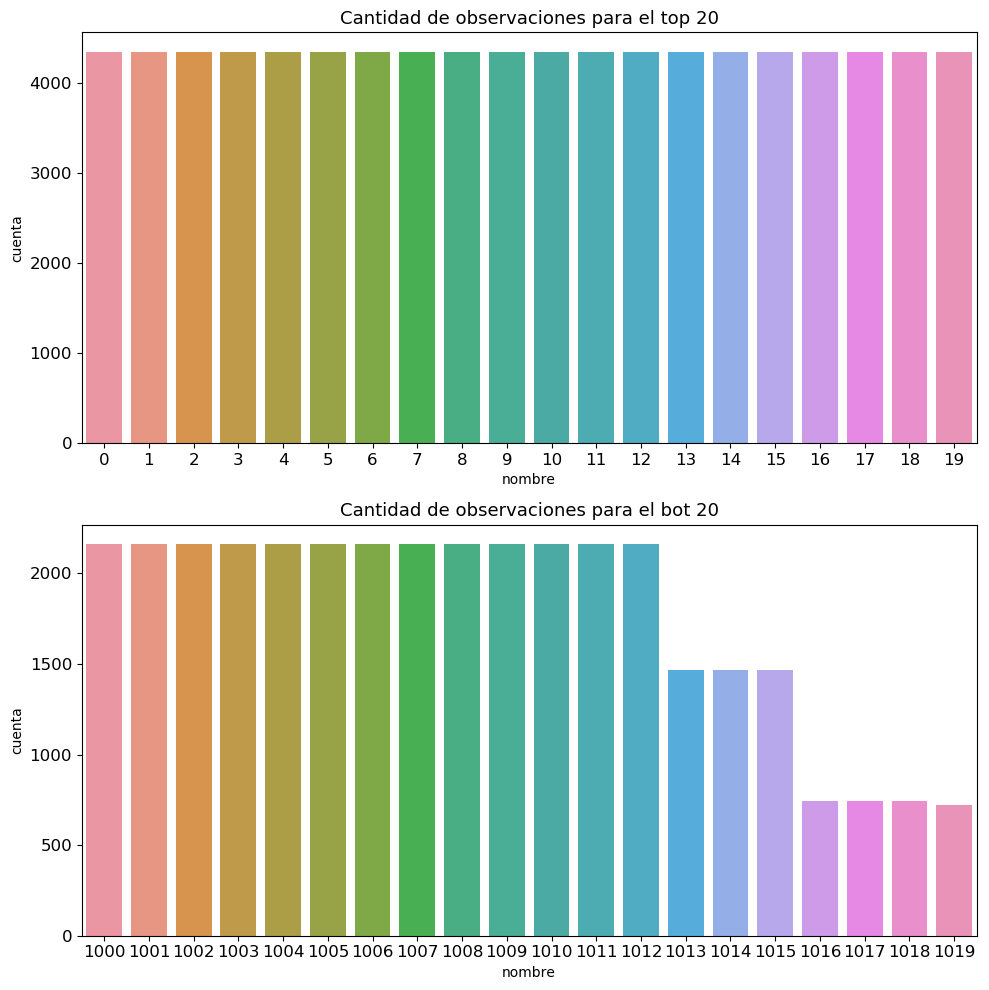

In [8]:
# Cuantas barras unicas existen?
def barras(costo_marginal, columna):
    print(f'Se analiza la columna {columna}')
    cuenta_unicas = costo_marginal[columna].nunique()
    print(f'Existen {cuenta_unicas} datos unicos en nuestro columna {columna}')
    dist = costo_marginal[[columna, 'fecha']]
    dist = dist.groupby([columna])['fecha'].count().reset_index()
    dist.columns = [columna, 'cuenta']
    dist.sort_values('cuenta', ascending = False, inplace = True)
    dist['nombre'] = np.arange(dist.shape[0])
    fig, axes = plt.subplots(nrows = 2, ncols = 1, figsize = (10 , 10), dpi = 100)
    sns.barplot(x = dist['nombre'].iloc[:20], y = dist['cuenta'].iloc[:20], ax = axes[0])
    sns.barplot(x = dist['nombre'].iloc[-20:], y = dist['cuenta'].iloc[-20:], ax = axes[1])
    axes[0].tick_params(axis = 'x', labelsize = 12)
    axes[0].tick_params(axis = 'y', labelsize = 12)
    axes[1].tick_params(axis = 'x', labelsize = 12)
    axes[1].tick_params(axis = 'y', labelsize = 12)
    axes[0].set_title('Cantidad de observaciones para el top 20', fontsize = 13)
    axes[1].set_title('Cantidad de observaciones para el bot 20', fontsize = 13)
    plt.tight_layout()
    plt.show()
    return dist
    
barra_dist = barras(costo_marginal, 'barra_mnemotecnico')

Se puede ver que la cantidad de observaciones por barra varia con maximos por sobre los 4000 registros y un minimo de 720

In [9]:
cmr['barra_referencia_mnemotecnico'].unique()

array(['BA02T002SE032T002'], dtype=object)

Para la columns barra_referencia_mnemotecnico existe solo un registro unico

Se analiza la columna nombre
Existen 1020 datos unicos en nuestro columna nombre


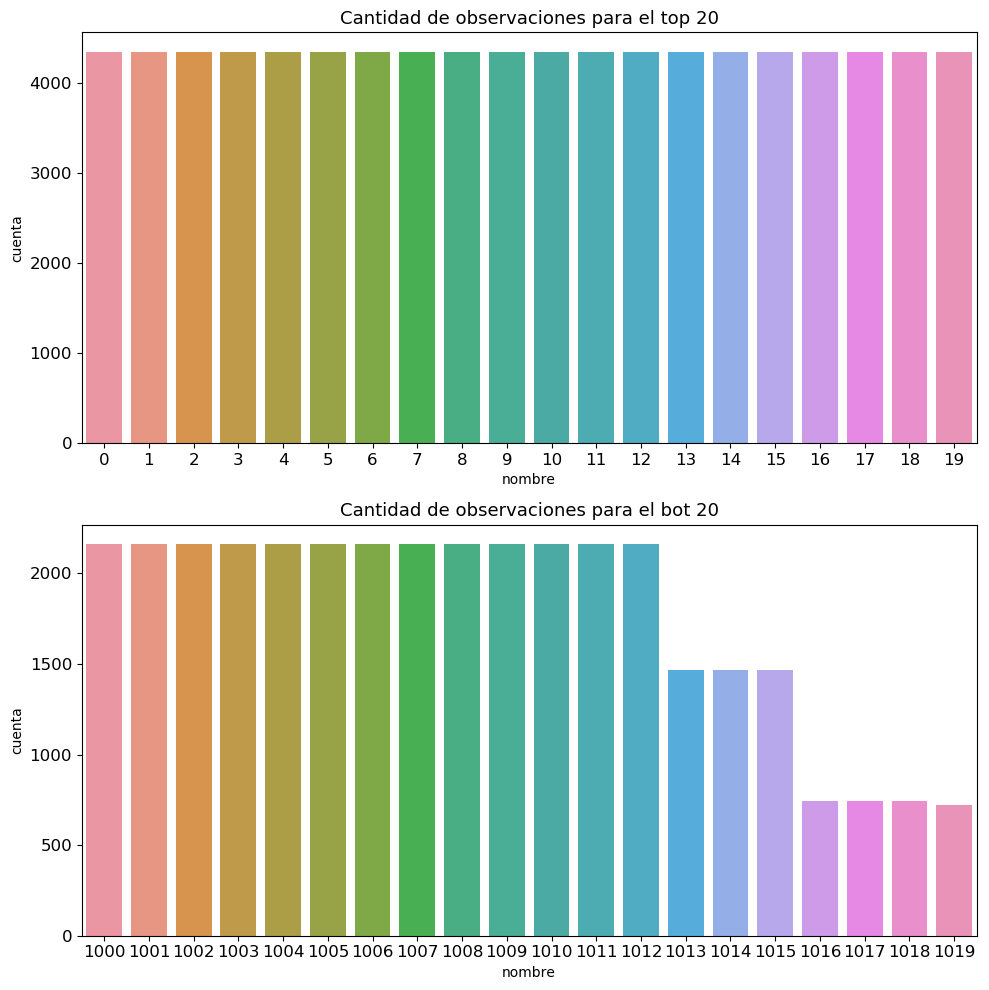

In [10]:
nombre_dist = barras(costo_marginal, 'nombre')

La misma distribucion para los nombres, al parecer cada barra esta relacionado a un nombre unico en especifico. Verifiquemos esto haciendo una simple operacion utilizando el dataset de origen

In [11]:
tmp = cmr.groupby(['barra_mnemotecnico', 'nombre'])['fecha'].count().reset_index()
dim = len(tmp)
if dim == 1020:
    print('Efectivamente cada barra esta relacionada a un nombre en especifico')
else:
    print('Estabamos equivocados, existe mas de un nombre por cada barra')

Efectivamente cada barra esta relacionada a un nombre en especifico


Si ponemos atencion podemos ver que esta relacion estaba clara desde antes, dado que el merge entre ambas tablas tambien lo hicimos con el nombre

# Fecha y Hora

In [12]:
min_fecha = costo_marginal['fecha'].min()
max_fecha = costo_marginal['fecha'].max()
n_dias = costo_marginal['fecha'].nunique()
print(f'Nuestro dataset tiene data desde el {min_fecha} hasta el {max_fecha} lo cual equivale a {n_dias} dias')

Nuestro dataset tiene data desde el 2019-01-01 hasta el 2019-06-30 lo cual equivale a 181 dias


In [13]:
n_horas = costo_marginal['hora'].nunique()
horas = costo_marginal['hora'].unique()
print(f'Nuestro dataset tiene {n_horas} horas unicas, estas son:')
print(list(horas))

Nuestro dataset tiene 25 horas unicas, estas son:
[25, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]


Poner atencion a esto, por alguna razon existe la hora 25 lo cual no tiene mucho sentido dado que un dia contiene solamente 24 horas

Text(0.5, 1.0, 'Cantidad de observaciones por hora')

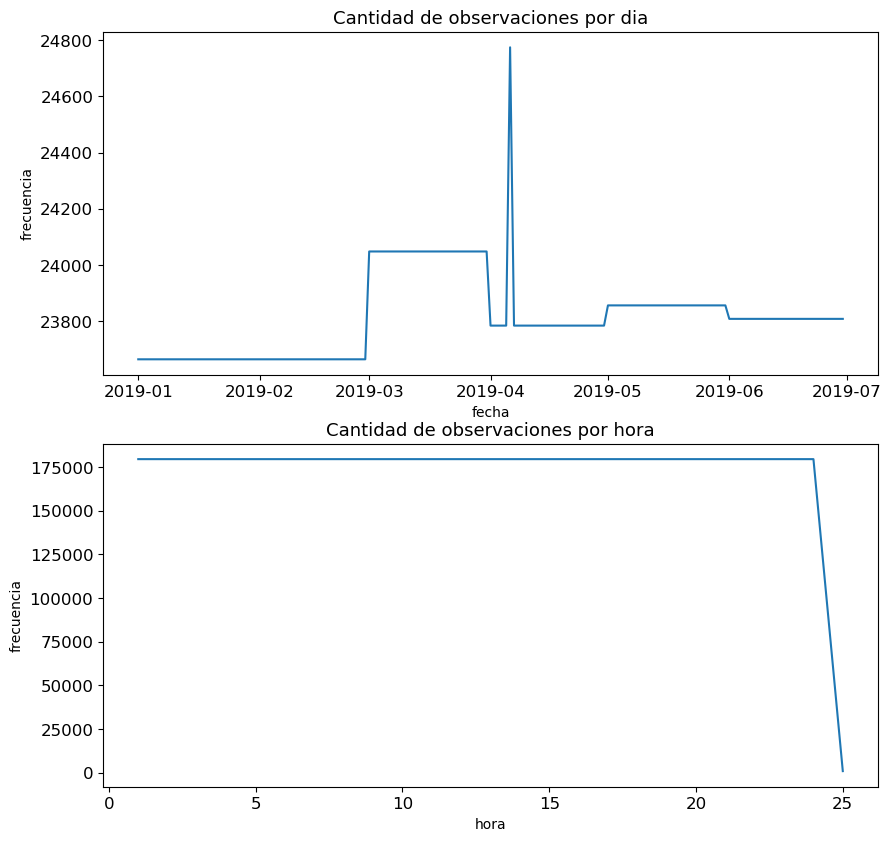

In [14]:
serie_dia = costo_marginal.groupby(['fecha'])['barra_mnemotecnico'].count().reset_index()
serie_dia.columns = ['fecha', 'frecuencia']
serie_dia['fecha'] = pd.to_datetime(serie_dia['fecha'])

serie_hora = costo_marginal.groupby(['hora'])['barra_mnemotecnico'].count().reset_index()
serie_hora.columns = ['hora', 'frecuencia']

fig, axes = plt.subplots(nrows = 2, ncols = 1, figsize = (10 , 10), dpi = 100)
sns.lineplot(x = serie_dia['fecha'], y = serie_dia['frecuencia'], ax = axes[0])
sns.lineplot(x = serie_hora['hora'], y = serie_hora['frecuencia'], ax = axes[1])
axes[0].tick_params(axis = 'x', labelsize = 12)
axes[0].tick_params(axis = 'y', labelsize = 12)
axes[1].tick_params(axis = 'x', labelsize = 12)
axes[1].tick_params(axis = 'y', labelsize = 12)
axes[0].set_title('Cantidad de observaciones por dia', fontsize = 13)
axes[1].set_title('Cantidad de observaciones por hora', fontsize = 13)

* Tenemos distintas cantidad de observaciones por dia, pero nominalmente no varia tanto. El maximo menos el minimo es 1111 de un total 24 mil registros aprox

* La cantidad de observaciones se ve constante para todas las horas del dia menos la hora 25. Puede ser que sea un error y esos registros esten mal anotados?, es muy probable, deberiamos cambiarla por 24 en el caso de que hagamos un modelo

# Costo_en_dolares, Costo_en_pesos & Costo

Me imagino que la variable costo_en_dolares y costo_en_pesos es igual si consideramos alguna transformacion que se realizo, de todas maneras veamos las distribuciones de estas variables continuas

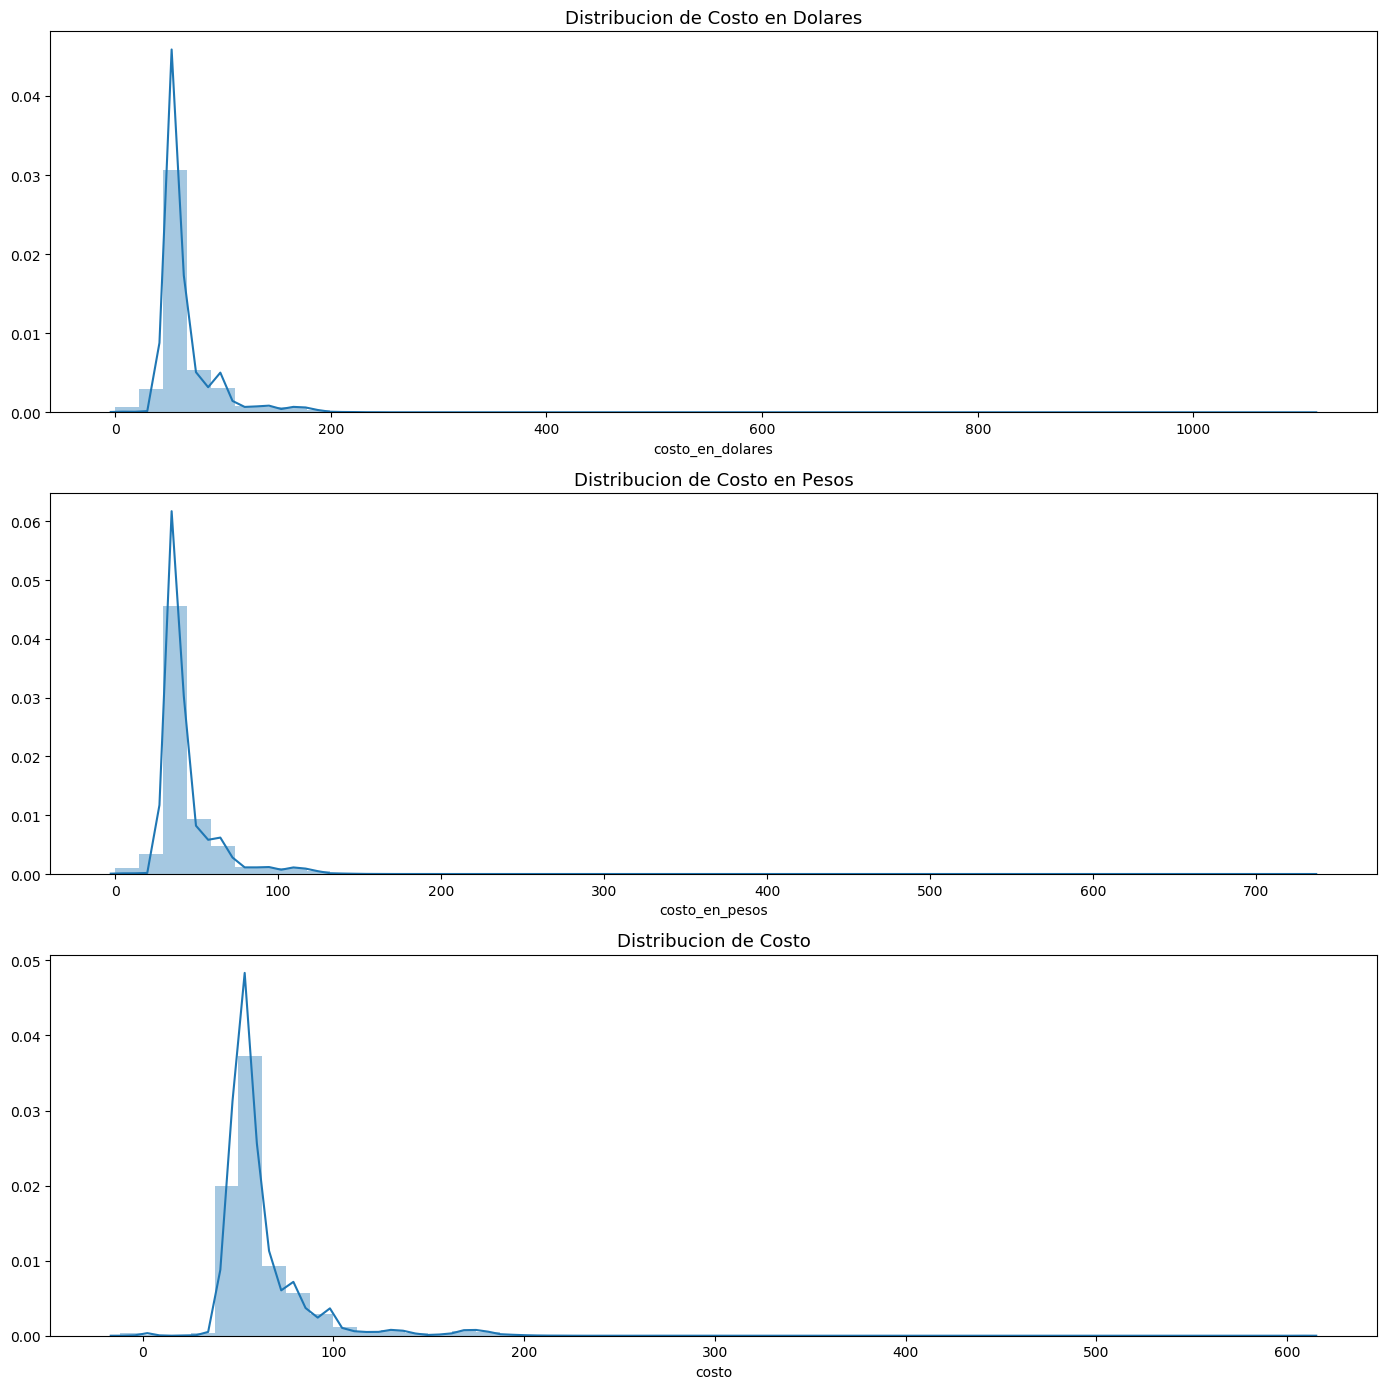

In [15]:
fig, axes = plt.subplots(nrows = 3, ncols = 1, figsize = (14 , 14), dpi = 100)
sns.distplot(costo_marginal['costo_en_dolares'], ax = axes[0])
sns.distplot(costo_marginal['costo_en_pesos'], ax = axes[1])
# Hay que filtrar los valores nulos de la variable costos
sns.distplot(costo_marginal['costo'].dropna(), ax = axes[2])
axes[0].set_title('Distribucion de Costo en Dolares', fontsize = 13)
axes[1].set_title('Distribucion de Costo en Pesos', fontsize = 13)
axes[2].set_title('Distribucion de Costo', fontsize = 13)
plt.tight_layout()

* Se puede ver que todas tiene un "Skewness positivo, cola a la derecha"

* Se puede ver que la distribucion de costo en dolares es identica a la distribucion de costo en pesos, de hecho la ecuacion es la siguiente costo en dolares * 0.66632 = costo en pesos

# Pregunta Barra

Ahora responderemos la pregunta, tenemos que calcular para cuantas barras se programa el costo, tengamos en mente que existen 1020 barras unicas

In [16]:
promedio_barra = costo_marginal.groupby(['barra_mnemotecnico'])['costo'].mean().reset_index()
barras_nulas = promedio_barra.isnull().sum()[1]
print(f'Tenemos {1020 - barras_nulas} barras en la cuales de programa el costo de un total de \
1020 barras unicas, la cual representa un {round((1020 - barras_nulas) / 1020, 4) * 100}% del total')

Tenemos 220 barras en la cuales de programa el costo de un total de 1020 barras unicas, la cual representa un 21.57% del total


# 2.0 Construccion de Variables

Los costo como se puede ver el enunciado es en dolares

* Costos marginales reales [USD/MWh] a nivel de barra y hora (cada fila es una barra y día-hora).

* Costos marginales programados [USD/MWh] (por el SIC) a nivel de barra y hora (cada fila es una barra y día-hora)

En este caso usaremos la columna costo_en_dolares para realizar las operaciones

In [17]:
# Desviacion, la diferencia entre el costo real y el costo programado
costo_marginal.loc[costo_marginal['costo'].notnull(), 'desviacion'] = costo_marginal['costo_en_dolares'] - costo_marginal['costo']
# Desviacion_pct, la misma desviacion pero en porcentaje
costo_marginal.loc[costo_marginal['costo'].notnull(), 'desviacion_pct'] = ((costo_marginal['costo_en_dolares'] - costo_marginal['costo']) / costo_marginal['costo_en_dolares']) * 100
# Reemplazar los valores infinitos debido a las divisiones por 0 
costo_marginal.replace([np.inf, -np.inf], np.nan, inplace = True)
# Desviacion_cat, vale 1 si la desviacion_pct absoluta es mayor a 15% o menor a -15%
costo_marginal.loc[(costo_marginal['desviacion_pct'].notnull()) & ((costo_marginal['desviacion_pct'] > 15) | (costo_marginal['desviacion_pct'] < -15)), 'desviacion_cat'] = 1
# Reemplazar los valores restantes por 0 indicando que no se cumple la condicion
costo_marginal.loc[(costo_marginal['desviacion_pct'].notnull()) & (costo_marginal['desviacion_cat'].isnull()), 'desviacion_cat'] = 0

Algunos valores tiene un costo_en_dolares de 0 por lo tanto la desviacion_pct es indifinida

La variable desviacion_pct cambian en el tiempo?

El promedio y la desviacion estandar del promedio de la desviacion_cat es 0.157077107747239 y 0.25154879462793395


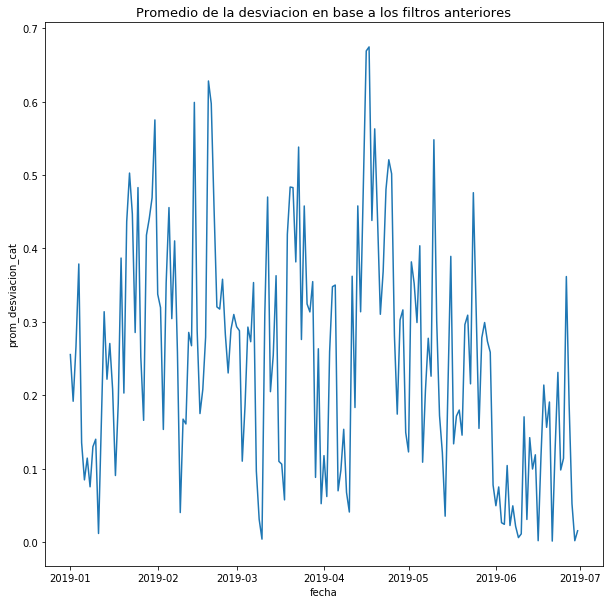

In [18]:
promedio_dcat = costo_marginal.groupby(['fecha'])['desviacion_cat'].mean().reset_index()
promedio_dcat.columns = ['fecha', 'prom_desviacion_cat']
promedio_dcat['fecha'] = pd.to_datetime(promedio_dcat['fecha'])
plt.figure(figsize = (10, 10))
sns.lineplot(x = promedio_dcat['fecha'], y = promedio_dcat['prom_desviacion_cat'])
plt.title('Promedio de la desviacion en base a los filtros anteriores', fontsize = 13)
des_est = promedio_dcat['prom_desviacion_cat'].std()
promedio = promedio_dcat['prom_desviacion_cat'].mean()
print(f'El promedio y la desviacion estandar del promedio de la desviacion_cat \
es {des_est} y {promedio}')

Desviacion_cat cambia mucho a traves del tiempo, se puede observar una alta desviacion estandar.

# 3.0 Visualizacion de datos

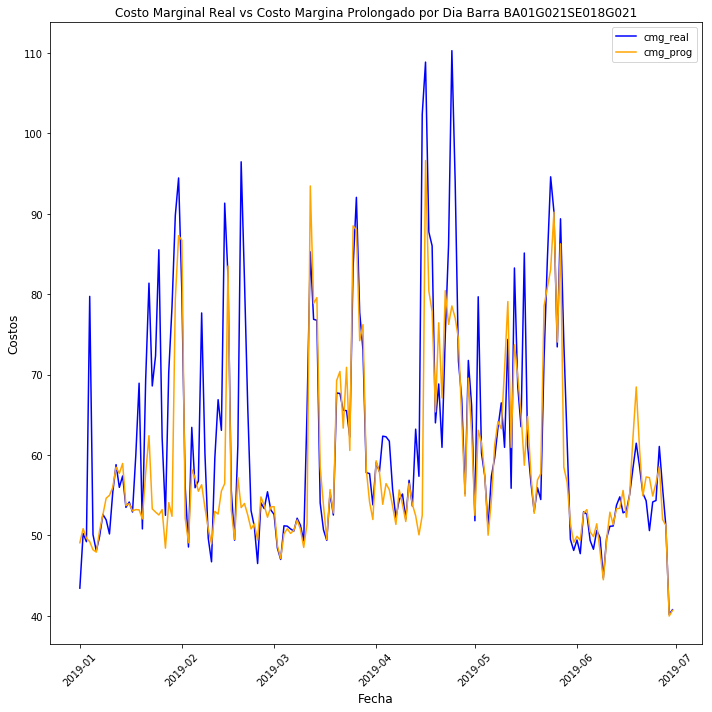

In [19]:
def time_plot_costo_barra(codigo_barra, fecha_inicial, fecha_final):
    # Filtramos el codigo barra que queremos graficar
    tmp = costo_marginal[costo_marginal['barra_mnemotecnico']==codigo_barra]
    # Filtramos el periodo de tiempo con la fecha inicial y final
    tmp = tmp[(tmp['fecha'] >= fecha_inicial) & (tmp['fecha'] <= fecha_final)]
    # Transformamos nuestra variable fecha a tipo date
    tmp['fecha'] = pd.to_datetime(tmp['fecha'])
    # Calculemos el promedio diario de los costos
    tmp = tmp.groupby(['fecha'])['costo_en_dolares', 'costo'].mean().reset_index()
    plt.figure(figsize = (10, 10))
    plt.plot(tmp['fecha'], tmp['costo_en_dolares'], label = 'cmg_real', 
                 color = 'blue')
    plt.plot(tmp['fecha'], tmp['costo'], label = 'cmg_prog', 
                 color = 'orange')
    plt.tick_params(axis = 'x', labelsize = 10, rotation = 45)
    plt.tick_params(axis = 'y', labelsize = 10)
    plt.xlabel('Fecha', fontsize = 12)
    plt.ylabel('Costos', fontsize = 12)
    plt.title(f'Costo Marginal Real vs Costo Margina Prolongado por Dia Barra {codigo_barra}')
    plt.legend()
    plt.tight_layout()
    plt.show()
    return tmp['fecha']
    
fechas = time_plot_costo_barra('BA01G021SE018G021', '2019-01-01', '2019-06-30')

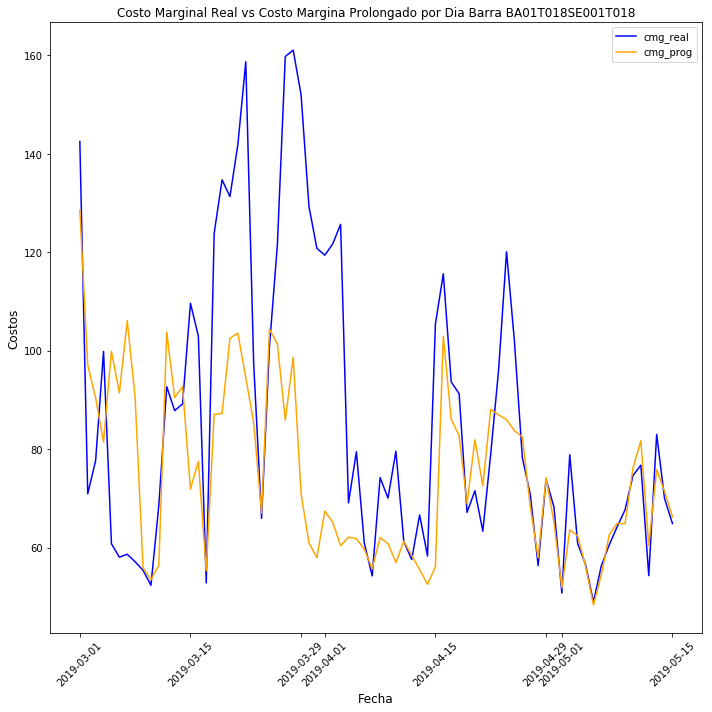

In [20]:
fechas = time_plot_costo_barra('BA01T018SE001T018', '2019-03-01', '2019-05-15')

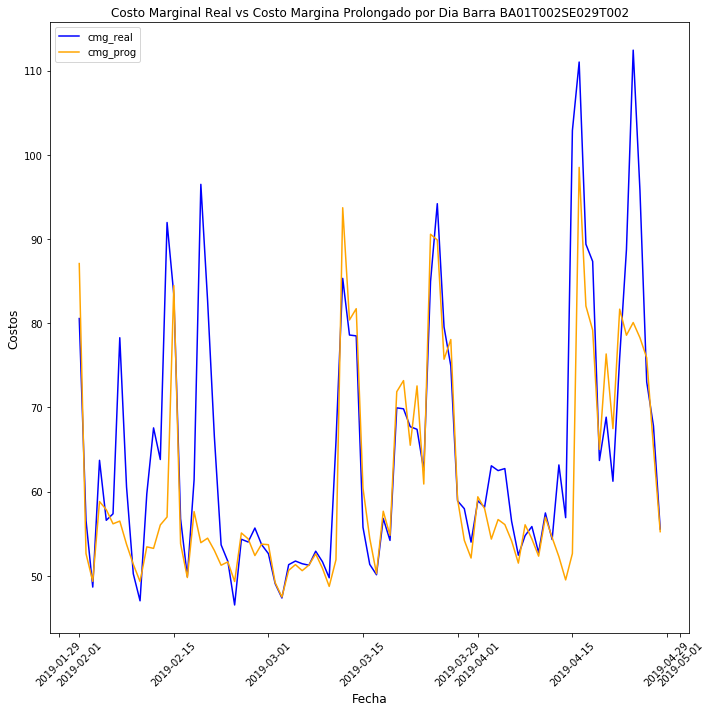

In [21]:
fechas = time_plot_costo_barra('BA01T002SE029T002', '2019-02-01', '2019-04-28')

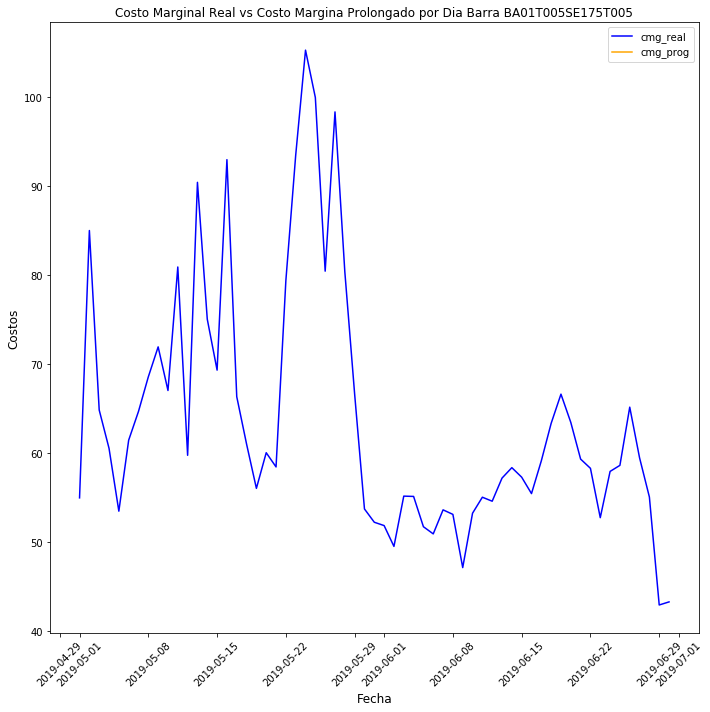

In [22]:
fechas = time_plot_costo_barra('BA01T005SE175T005', '2019-05-01', '2019-06-30')

* Se puede observar que algunas barras no tienen un costo marginal prolongado
* Cada barra tiene su propio rango de costos, por ejemplo la barra BA01T018SE001T018 es la mas alta

Eliminemos la bara que tiene costo marginal real = 0 durante todos los dias

In [23]:
tmp = costo_marginal[costo_marginal['costo_en_dolares']==0]
unique_barras = list(tmp['barra_mnemotecnico'].unique())
for barra in tqdm(unique_barras):
    tmp_ = costo_marginal[costo_marginal['barra_mnemotecnico'] == barra]
    costo_total = tmp_['costo_en_dolares'].sum()
    if costo_total == 0:
        print(f'La bara {barra} tiene costo marginal real equivalente a 0 durante todos los dias')
        print('Se elimina esta barra del dataset')
        costo_marginal = costo_marginal[costo_marginal['barra_mnemotecnico']!=barra]
        costo_marginal.reset_index(inplace = True, drop = True)

  0%|                                                                                          | 0/345 [00:00<?, ?it/s]

La bara BA01G049SE001G049 tiene costo marginal real equivalente a 0 durante todos los dias
Se elimina esta barra del dataset


  0%|▏                                                                                 | 1/345 [00:00<03:41,  1.55it/s]

La bara BA02T005SE082T005 tiene costo marginal real equivalente a 0 durante todos los dias
Se elimina esta barra del dataset


  1%|▍                                                                                 | 2/345 [00:01<03:42,  1.54it/s]

La bara BA02T005SE046T005 tiene costo marginal real equivalente a 0 durante todos los dias
Se elimina esta barra del dataset


  1%|▋                                                                                 | 3/345 [00:01<03:40,  1.55it/s]

La bara BA01L038SE001L038 tiene costo marginal real equivalente a 0 durante todos los dias
Se elimina esta barra del dataset


  1%|▉                                                                                 | 4/345 [00:02<03:40,  1.55it/s]

La bara BA02T003SE009T003 tiene costo marginal real equivalente a 0 durante todos los dias
Se elimina esta barra del dataset


100%|████████████████████████████████████████████████████████████████████████████████| 345/345 [01:13<00:00,  5.07it/s]


Se encontraron 5 barras que tienen un costo marginal real equivalente a 0 durante todos los dias

# 4.0 Base Para Los Modelos

In [24]:
# Cargamos el archivo costo_marginal_real.csv
data = read_dataset('base_para_prediccion.csv', 'base para predicction')
data.head()

Nuestro dataset base para predicction tiene 112779 filas y 15 columnas
Nuestro dataset base para predicction tiene 112779 filas y 15 columnas despues de eliminar las filas duplicadas


,nemotecnico_se,fecha,hora,gen_eolica_total_mwh,gen_geotermica_total_mwh,gen_hidraulica_total_mwh,gen_solar_total_mwh,gen_termica_total_mwh,cmg_real,cmg_prog,cmg_desv,cmg_desv_pct,n_barras,demanda_mwh,cap_inst_mw
0,SE031G216,2019-01-04 00:00:00 UTC,1,NaN,NaN,NaN,NaN,0.0,56.2,55.627852,0.57,1.02,2,1210767,13.20785
1,SE031G216,2019-01-04 00:00:00 UTC,2,NaN,NaN,NaN,NaN,0.0,56.2,55.376645,0.82,1.48,2,113232,13.20785
2,SE031G216,2019-01-04 00:00:00 UTC,3,NaN,NaN,NaN,NaN,0.0,56.2,59.531891,-3.33,-5.59,2,1089415,13.20785
3,SE031G216,2019-01-04 00:00:00 UTC,4,NaN,NaN,NaN,NaN,0.0,56.2,174.378923,-118.18,-67.77,2,1096867,13.20785
4,SE031G216,2019-01-04 00:00:00 UTC,5,NaN,NaN,NaN,NaN,0.0,56.2,172.820310,-116.62,-67.48,2,1071851,13.20785


In [25]:
data.drop_duplicates(subset = ['nemotecnico_se', 'fecha', 'hora']).shape

(112779, 15)

In [26]:
data.dtypes

nemotecnico_se               object
fecha                        object
hora                          int64
gen_eolica_total_mwh        float64
gen_geotermica_total_mwh    float64
gen_hidraulica_total_mwh    float64
gen_solar_total_mwh         float64
gen_termica_total_mwh       float64
cmg_real                    float64
cmg_prog                    float64
cmg_desv                    float64
cmg_desv_pct                float64
n_barras                      int64
demanda_mwh                   int64
cap_inst_mw                 float64
dtype: object

* Tenemos solamente 1 variable categorica la cual es nemotecnico_se
* Tenemos 1 variable que corresponde a la fecha de tipo object la cual la transformaremos a datetime
* El resto de las variables son float64 o int64 y al parecer son continuas

In [27]:
df = pd.DataFrame(data.isnull().sum()).reset_index()
df.columns = ['columnas', 'cantidad_nans']
df['porcentaje'] = round(df['cantidad_nans'] / data.shape[0], 3)
df

,columnas,cantidad_nans,porcentaje
0,nemotecnico_se,0,0.000
1,fecha,0,0.000
2,hora,0,0.000
3,gen_eolica_total_mwh,112779,1.000
4,gen_geotermica_total_mwh,112779,1.000
5,gen_hidraulica_total_mwh,78595,0.697
6,gen_solar_total_mwh,70961,0.629
7,gen_termica_total_mwh,50916,0.451
8,cmg_real,0,0.000
9,cmg_prog,0,0.000


* Las variables gen_eolica_total_mwh y gen_geotermica_total_mwh tienen todas las observaciones vacias
* La variables gen_hidraulica_total_mwh  tiene un 70% de sus observaciones vacias
* La variable gen_solar_total_mwh tienen mas de un 63% de sus valores vacios 
* La variable gen_termica_total_mwh tiene un 45% de sus valores vacios

In [28]:
fecha_min = data['fecha'].min()
fecha_max = data['fecha'].max()
n_dias = data['fecha'].nunique()
print(f'Tenemos data desde el {fecha_min} hasta el {fecha_max}')
print(f'Tenemos {n_dias} dias unicos en nuestra data')

Tenemos data desde el 2019-01-01 00:00:00 UTC hasta el 2019-06-30 00:00:00 UTC
Tenemos 181 dias unicos en nuestra data


Tenemos el mismo rango de fechas que el dataset anterior con la misma cantidad de dias unicos

Creemos mas variables a partir de la fecha

In [29]:
# Transformamos nuestra variable a tipo fecha
data['fecha'] = pd.to_datetime(data['fecha'])
# Obtenemso el año, mes, semana del año, dia del calendario, dia de la semana
data['año'] = data['fecha'].dt.year
data['mes'] = data['fecha'].dt.month
data['semana_del_año'] = data['fecha'].dt.week
data['dia_calendario'] = data['fecha'].dt.dayofyear
data['dia_semana'] = data['fecha'].dt.dayofweek
# Variable binaria para indicar si es fin de semana o dia de semana
data.loc[data['dia_semana'].isin([5, 6]), 'flg_fds'] = 1
data['flg_fds'].fillna(0, inplace = True)

In [30]:
data.head()

,nemotecnico_se,fecha,hora,gen_eolica_total_mwh,gen_geotermica_total_mwh,gen_hidraulica_total_mwh,gen_solar_total_mwh,gen_termica_total_mwh,cmg_real,cmg_prog,cmg_desv,cmg_desv_pct,n_barras,demanda_mwh,cap_inst_mw,año,mes,semana_del_año,dia_calendario,dia_semana,flg_fds
0,SE031G216,2019-01-04 00:00:00+00:00,1,NaN,NaN,NaN,NaN,0.0,56.2,55.627852,0.57,1.02,2,1210767,13.20785,2019,1,1,4,4,0.0
1,SE031G216,2019-01-04 00:00:00+00:00,2,NaN,NaN,NaN,NaN,0.0,56.2,55.376645,0.82,1.48,2,113232,13.20785,2019,1,1,4,4,0.0
2,SE031G216,2019-01-04 00:00:00+00:00,3,NaN,NaN,NaN,NaN,0.0,56.2,59.531891,-3.33,-5.59,2,1089415,13.20785,2019,1,1,4,4,0.0
3,SE031G216,2019-01-04 00:00:00+00:00,4,NaN,NaN,NaN,NaN,0.0,56.2,174.378923,-118.18,-67.77,2,1096867,13.20785,2019,1,1,4,4,0.0
4,SE031G216,2019-01-04 00:00:00+00:00,5,NaN,NaN,NaN,NaN,0.0,56.2,172.820310,-116.62,-67.48,2,1071851,13.20785,2019,1,1,4,4,0.0


La desviacion estandar para el dia 2019-01-10 es de 37.42049867404886


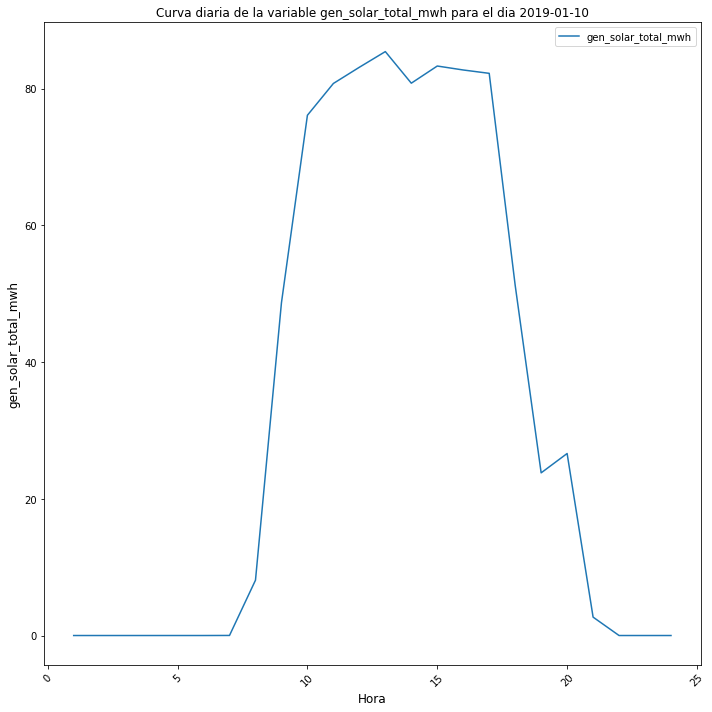

La desviacion estandar para el dia 2019-01-11 es de 38.74580844090274


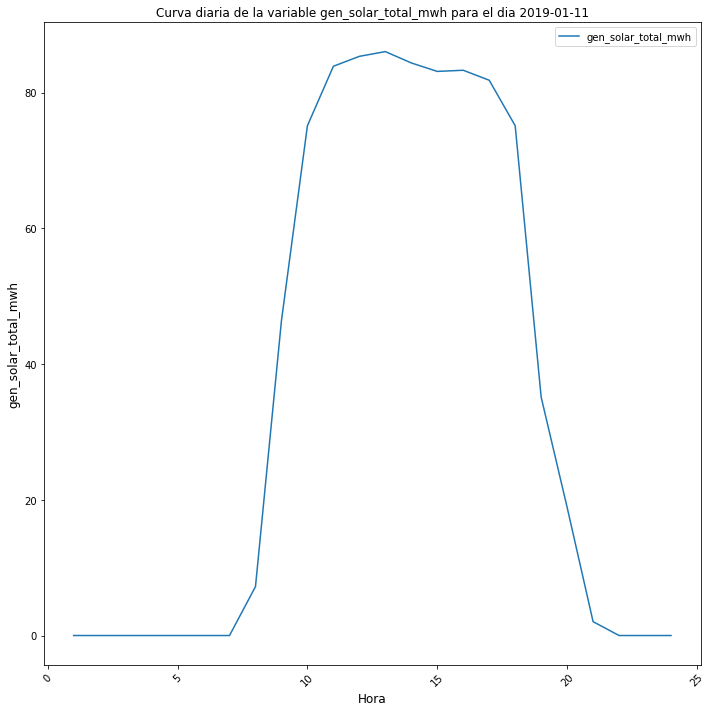

La desviacion estandar para el dia 2019-01-12 es de 37.49815775184974


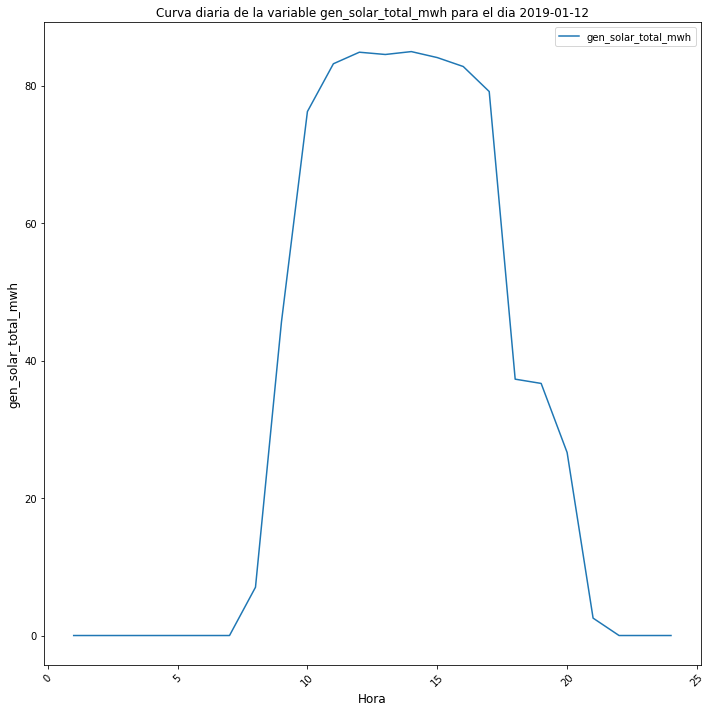

La desviacion estandar para el dia 2019-01-13 es de 38.813703707209065


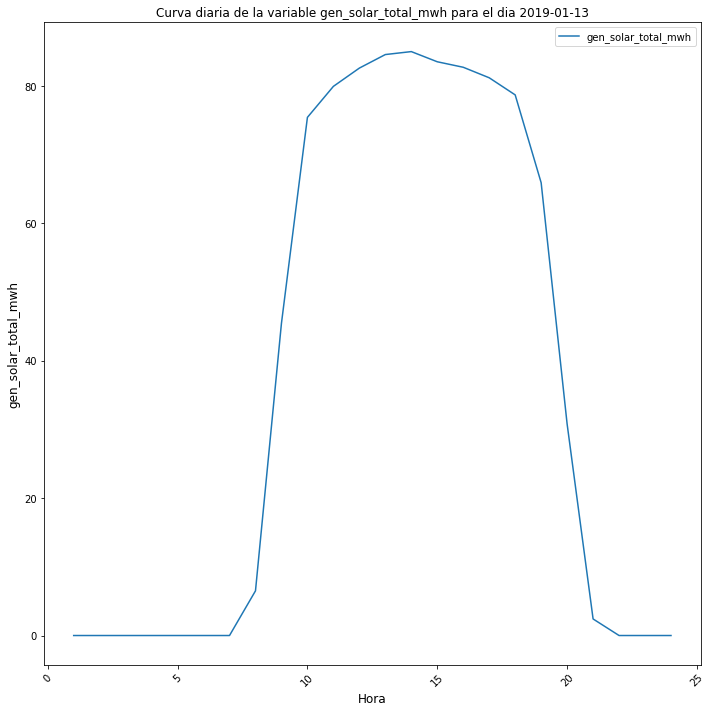

La desviacion estandar para el dia 2019-01-14 es de 38.07588138568957


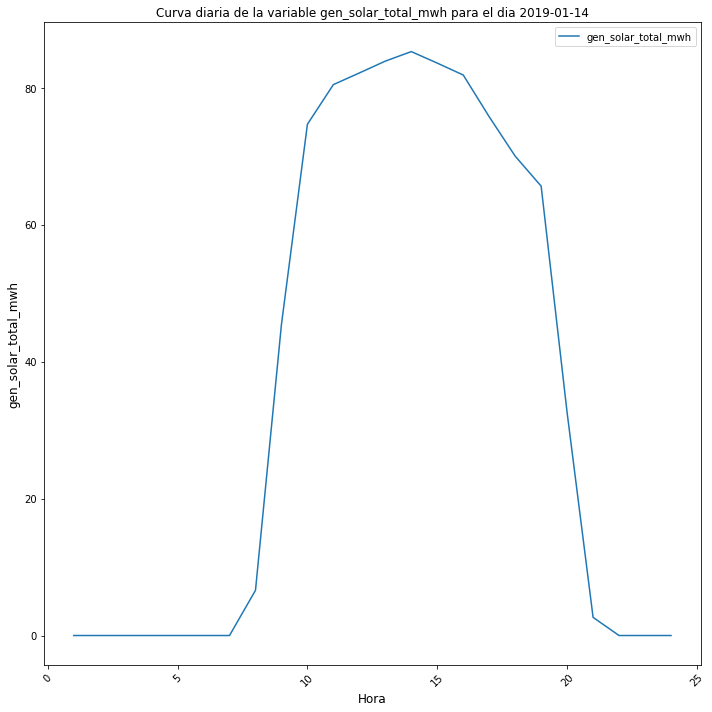

In [31]:
def serie_de_tiempo(subestacion, variable, fechas = ['2019-01-10', '2019-02-10']):
    # Filtramos la subestacion
    df = data[data['nemotecnico_se'] == subestacion]
    # Grafiquemos cada una de las fechas
    for fecha in fechas:
        # Filtramos la fecha que queremos graficar y la ordenamos de forma ascendente
        df_ = df[df['fecha'] == fecha].sort_values('hora')
        plt.figure(figsize = (10, 10))
        plt.plot(df_['hora'], df_[variable], label = variable)
        des = df_[variable].std()
        print(f'La desviacion estandar para el dia {fecha} es de {des}')
        plt.tick_params(axis = 'x', labelsize = 10, rotation = 45)
        plt.tick_params(axis = 'y', labelsize = 10)
        plt.xlabel('Hora', fontsize = 12)
        plt.ylabel(variable, fontsize = 12)
        plt.title(f'Curva diaria de la variable {variable} para el dia {fecha}')
        plt.legend()
        plt.tight_layout()
        plt.show()
        
serie_de_tiempo('SE005T002', 'gen_solar_total_mwh', ['2019-01-10', '2019-01-11', '2019-01-12', 
                                                     '2019-01-13', '2019-01-14'])

* Se puede ver que en general las curvas acienden a su peak a las 11 horas, y descienden dependiendo del dia, en este caso entre las horas 17 y 18 horas

* Las desviacion estandar esta entre 37.43 y 38.82 para todos los dias

La desviacion estandar para el dia 2019-01-10 es de 0.47628011199641757


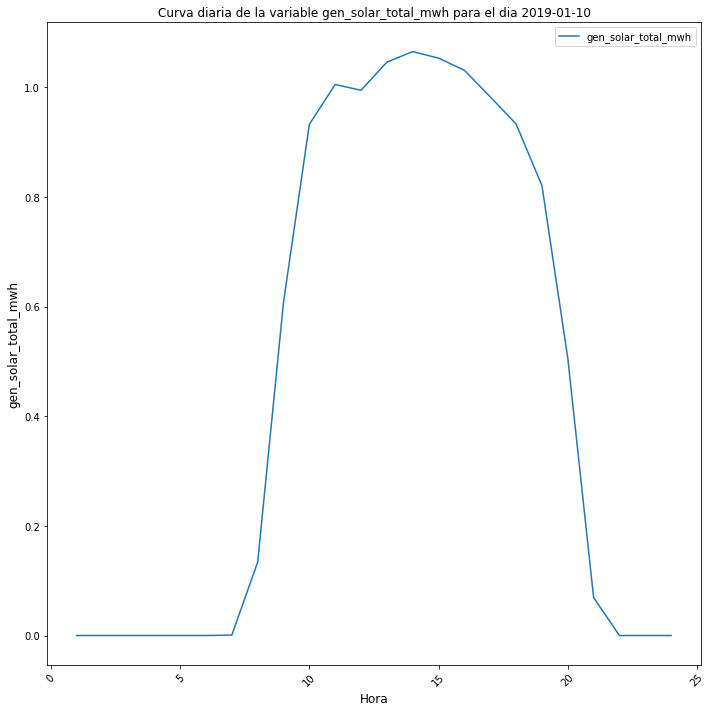

La desviacion estandar para el dia 2019-01-11 es de 0.46687795383084324


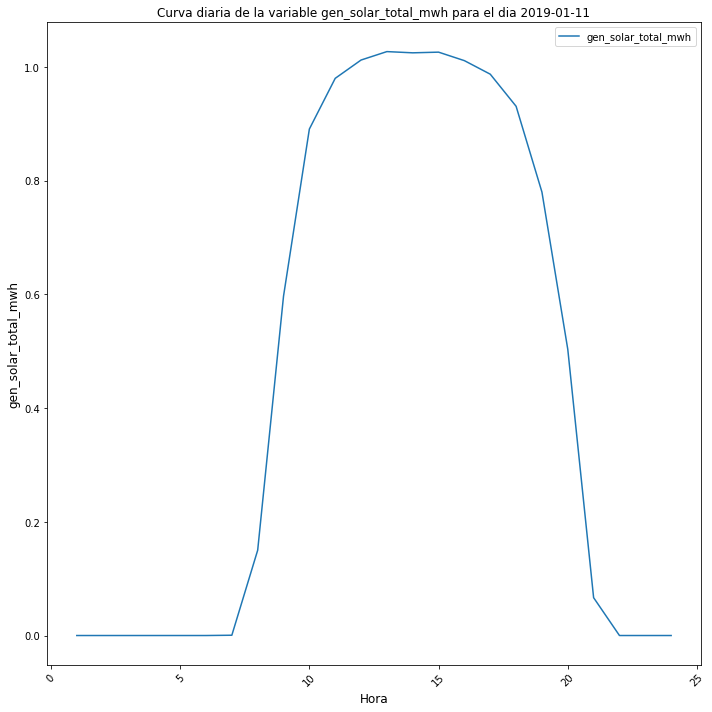

La desviacion estandar para el dia 2019-01-12 es de 0.3664544113509272


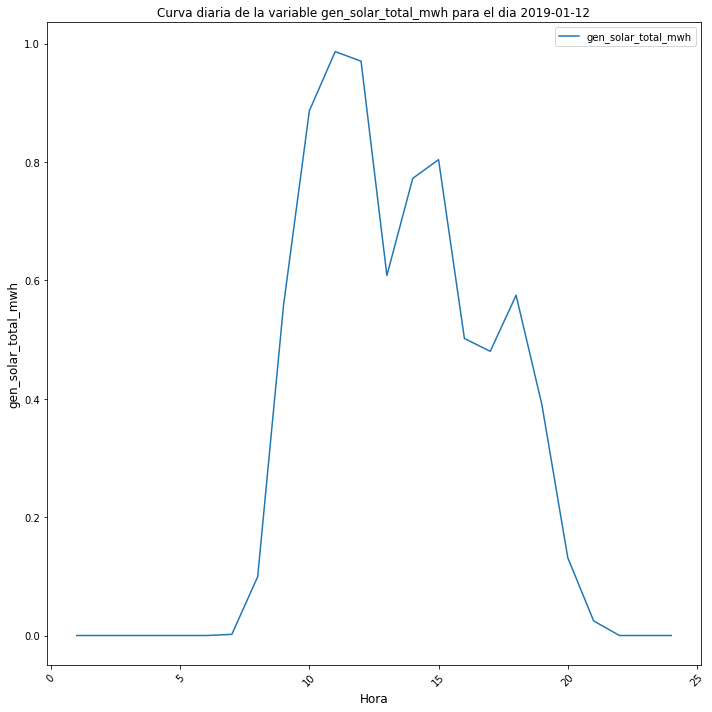

La desviacion estandar para el dia 2019-01-13 es de 0.45315865365587893


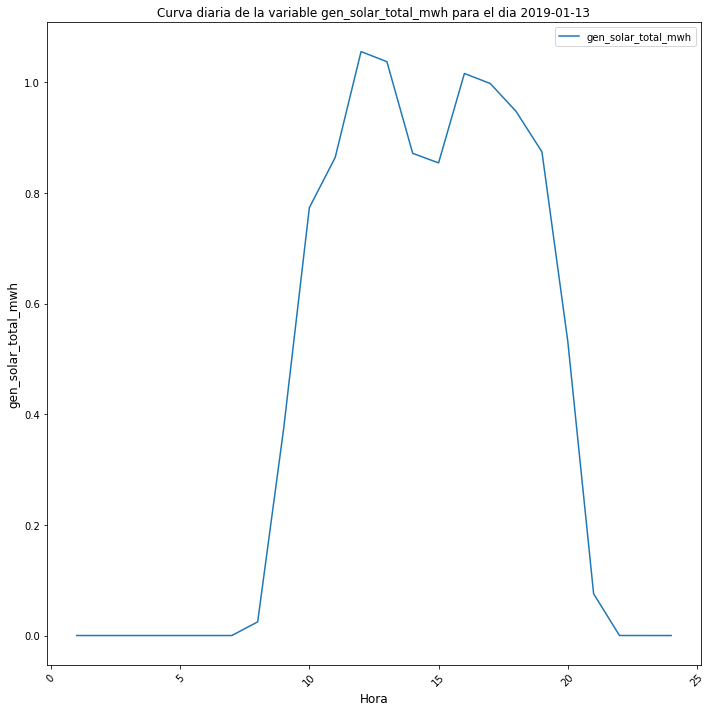

La desviacion estandar para el dia 2019-01-14 es de 0.45746204568242954


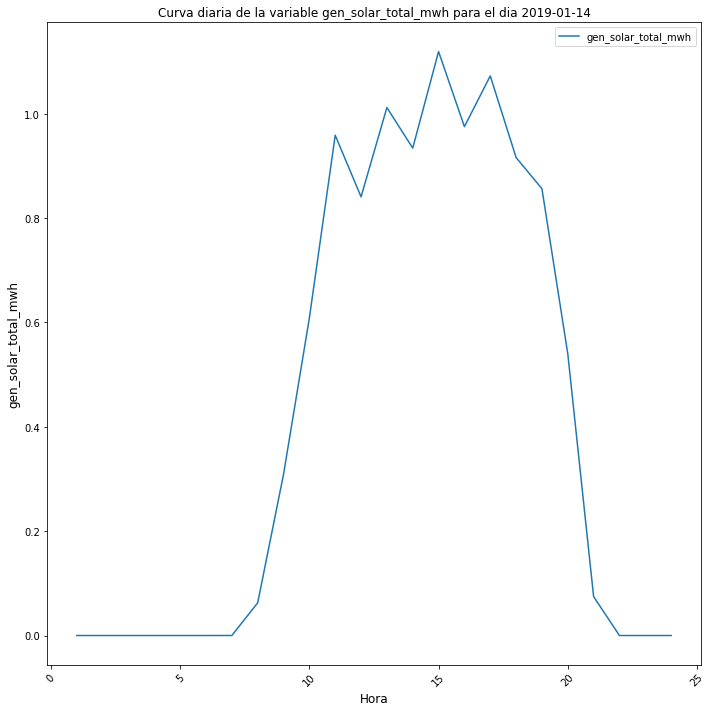

In [32]:
serie_de_tiempo('SE127T005', 'gen_solar_total_mwh', ['2019-01-10', '2019-01-11', '2019-01-12', 
                                                     '2019-01-13', '2019-01-14'])

* Se puede ver que la subestacion SE127T005 tiene un comportamiento parecido a la estacion SE005T002 para los dias 11 y 12 de Enero de 2019

* Se puede ver que la subestacion SE127T005 tiene un comportamiento distinto a la estacion SE005T002 para los dias 12, 13 y 14 de Enero. Para estos dias la estacion SE127T005 tiene fluctuaciones en su curva en los horario del peak

* El 12 de Enero de 2019 la subestacion SE127T005 tiene una desviacion estandar distinta en comparacion a los otros dias

La desviacion estandar para el dia 2019-05-14 es de 16.704110298503338


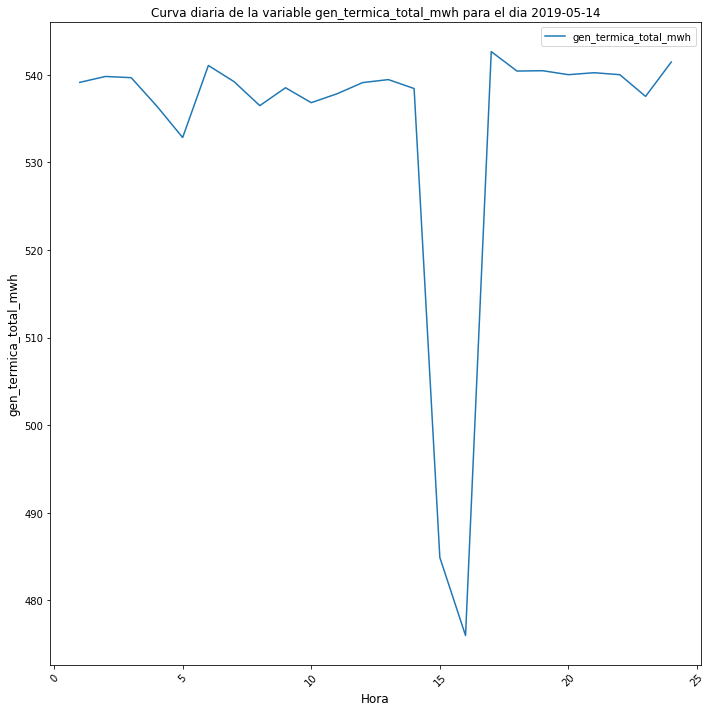

La desviacion estandar para el dia 2019-05-15 es de 3.177229033290157


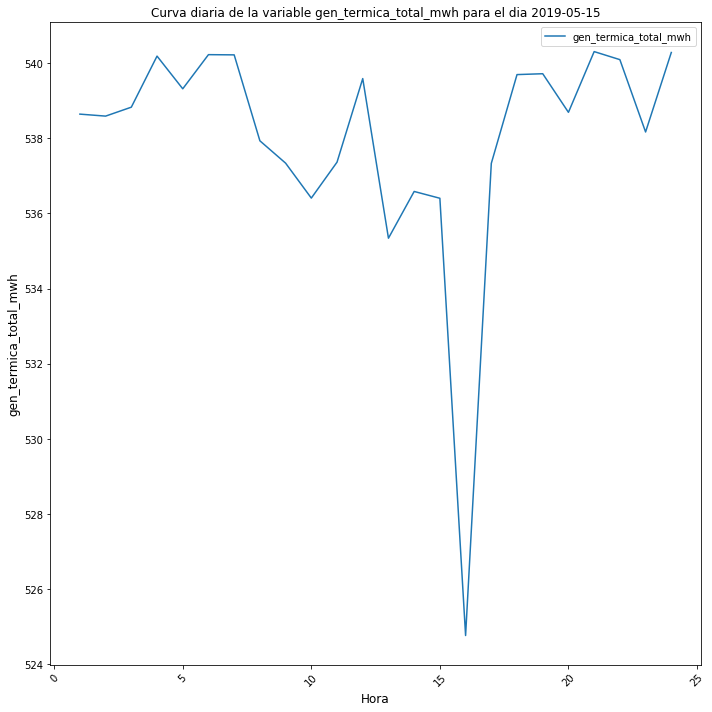

La desviacion estandar para el dia 2019-05-16 es de 39.26767792100531


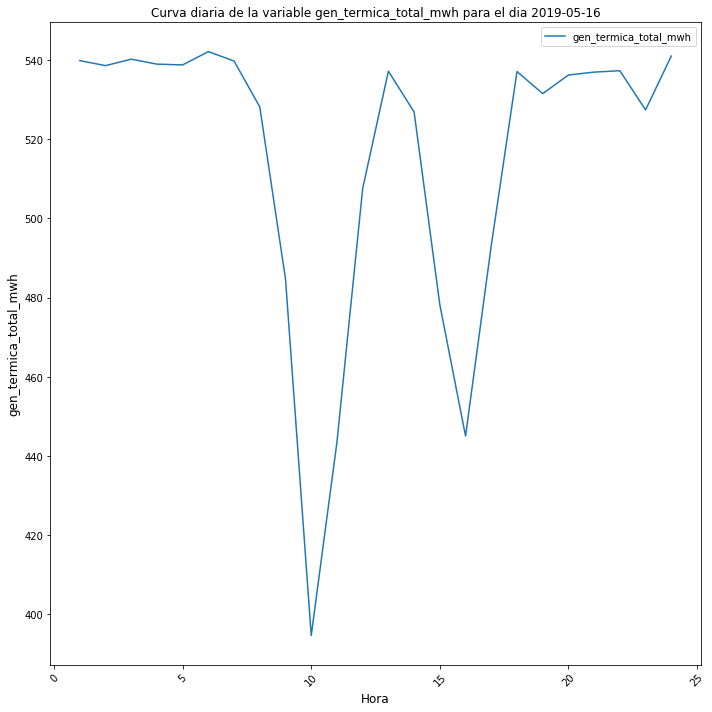

La desviacion estandar para el dia 2019-05-17 es de 20.416935622917617


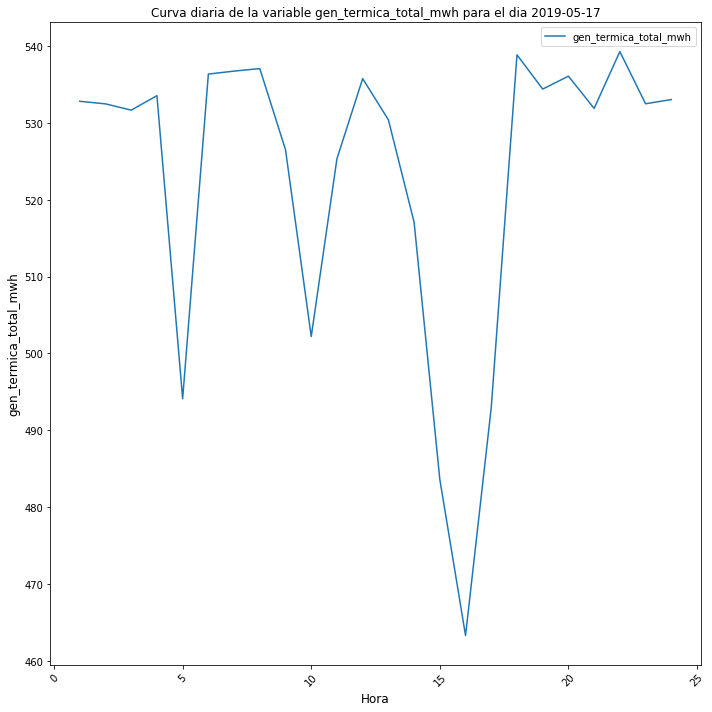

In [33]:
serie_de_tiempo('SE020G213', 'gen_termica_total_mwh', ['2019-05-14', '2019-05-15', '2019-05-16', 
                                                       '2019-05-17'])

* Para todas las curvas podemos ver unas bajas y subidas importantes para ciertas horas, en especial a las 16 horas

* Los minimos y maximo varias dependiendo del dia pero en general el maximo para todos los dias es de 540 approx

* La desviacion estandar es distinta para todos los dias

La desviacion estandar para el dia 2019-05-14 es de 0.25794679473302873


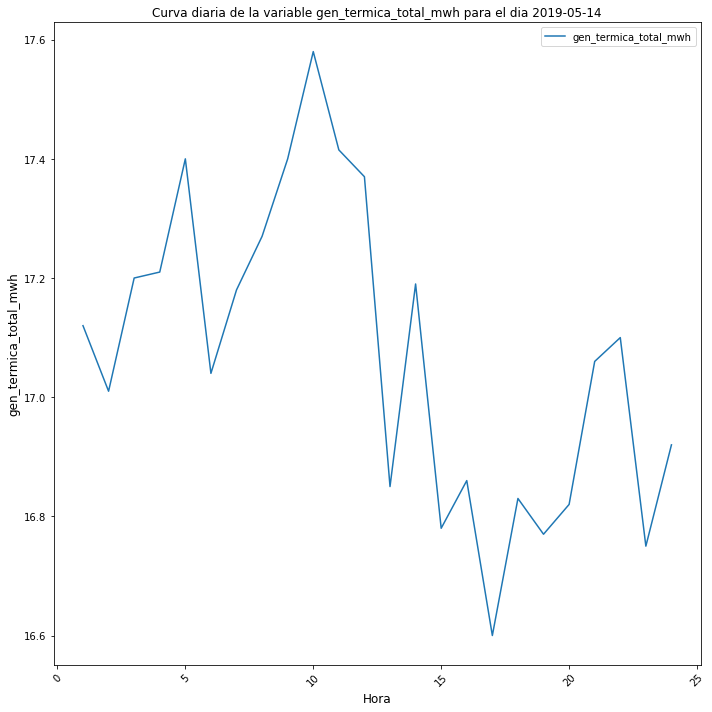

La desviacion estandar para el dia 2019-05-15 es de 0.5166439920223146


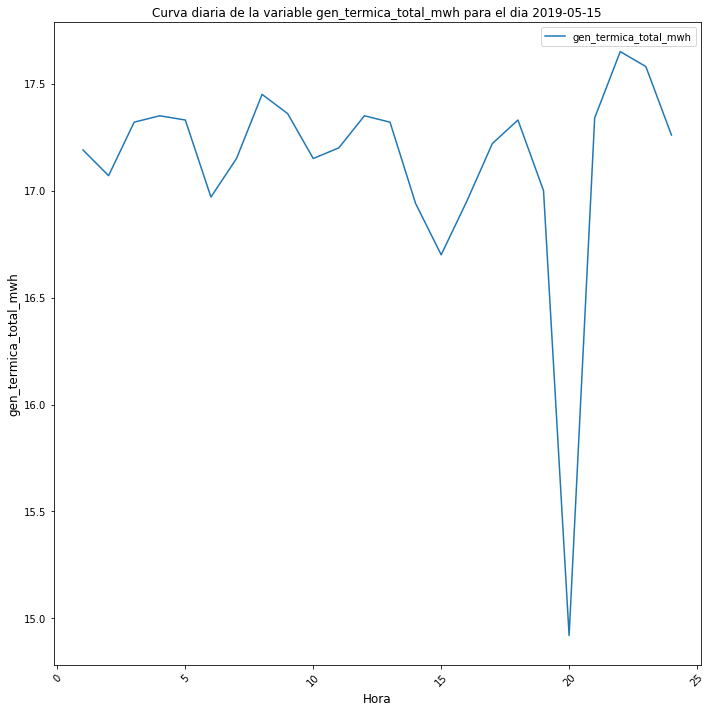

La desviacion estandar para el dia 2019-05-16 es de 0.22291871528247334


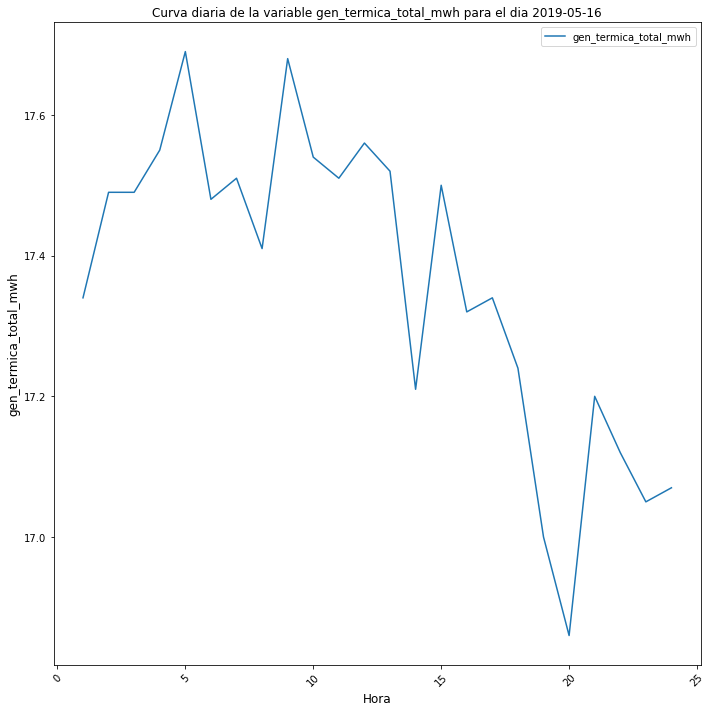

La desviacion estandar para el dia 2019-05-17 es de 0.2555212773692356


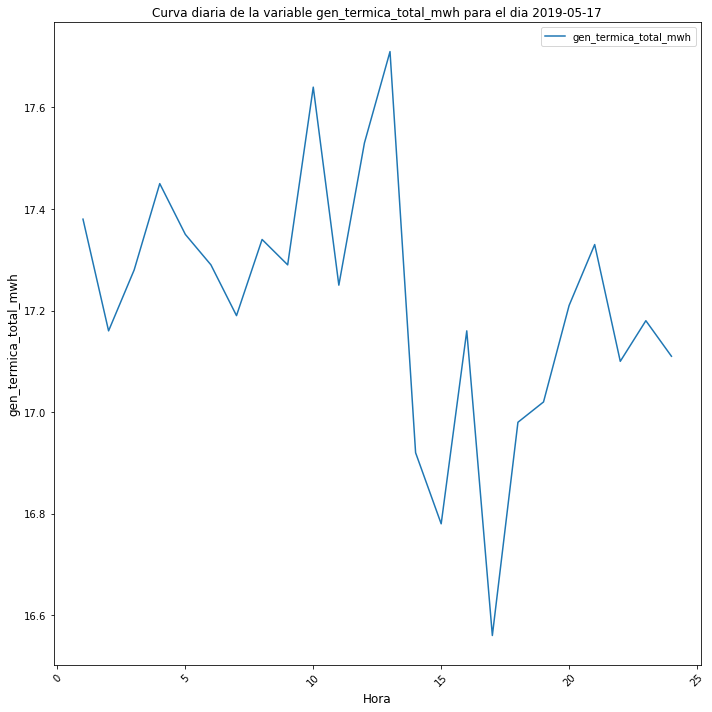

In [34]:
serie_de_tiempo('SE106G216', 'gen_termica_total_mwh', ['2019-05-14', '2019-05-15', '2019-05-16', 
                                                       '2019-05-17'])

* Los valores de generacion termica en general estan cercanos a los 17.2 mhw

* La subestacion SE106G216 tiene diferencias grandes entre todas sus horas, mientras que en la subestacion SE020G213 existen rangos de horas en donde cambia poco la medicion

* Para el dia 15 de Mayo de 2019 para la subestacion SE106G216 se puede ver una desviacion estandar bastante mas alta que en los otros dias, esto se debe a que existen un gran baja en la hora 20

# 5.0 Prediccion de desviaciones del costo marginal: modelo 1

Crearemos modelos bases, no sera el mejor modelo dado que para esto se requiere mucha experimentacion y exploracion de los datos.

Claramente esto es un problema de series de tiempo en donde es muy importante la estrategia de evaluacion de nuestros modelos porque es muy facil tener leakeage en este tipo de problemas

Importante: Cada subestacion es una serie de tiempo, y no todas tienen observaciones para todas las fechas-horas. Esto tambien se puede inlcuir en la resolucion del problema pero en este caso lo ignoraremos dado que es solo un ejercicio

In [35]:
# Funcion para realizar el preproceso indicado y entregar una copia para experimentar
def preprocess(data):
    # Creamos una copia de nuestra data para poder usarla en todos los ejercicios
    data_ = data.copy()
    # Creamos una variable target equivalente a 0 cuando esta entre -15 y 15
    data_.loc[(data_['cmg_desv_pct'] >= -15) & (data_['cmg_desv_pct'] <= 15), 'target'] = 0
    # Para el resto de los valores llenamos con 1
    data_['target'].fillna(1, inplace = True)
    # Sumamos la 5 generaciones (2 de ellas tiene solo valores vacios por lo tanto no tiene sentido sumarlas)
    data_['en_total_mwh'] = data_[['gen_hidraulica_total_mwh', 'gen_solar_total_mwh', 'gen_termica_total_mwh']].sum(axis = 1)
    # Descartamos las columnas que tienen solamente nulos
    data_.drop(['gen_eolica_total_mwh', 'gen_geotermica_total_mwh'], axis = 1, inplace = True)
    # Ordenamos nuestra data para realizar ingeniera de variables
    data_.sort_values(['nemotecnico_se', 'fecha', 'hora'], inplace = True)
    # Reordenamos el indice
    data_.reset_index(inplace = True, drop = True)
    # Transformamos nuestra barra (indicadore de serie de tiempo) a una variable categorica numerica
    encoder = preprocessing.LabelEncoder()
    data_['nemotecnico_se_en'] = encoder.fit_transform(data_['nemotecnico_se'])
    return data_

# Funcion para calcular lags de una variable
def lags(df, columns = ['en_total_mwh'], lags = [1, 2, 3, 4, 5, 6, 7, 8]):
    for column in columns:
        for lag in lags:
            df[f'{column}_lag{lag}'] = df.groupby(['nemotecnico_se'])[column].transform(lambda x: x.shift(lag))
    return df

# Funcion para calcular ventanas moviles (promedio, desviacion estandar, maximos y minimos)
def rolling_windows(df, columns = ['en_total_mwh'], windows = [4, 8, 16, 24, 168]):
    for column in columns:
        for window in windows:
            df[f'{column}_{window}_promedio'] = df.groupby(['nemotecnico_se'])[column].transform(lambda x: \
                                                                                                 x.rolling(window).mean())
            df[f'{column}_{window}_std'] = df.groupby(['nemotecnico_se'])[column].transform(lambda x: \
                                                                                            x.rolling(window).std())
            df[f'{column}_{window}_max'] = df.groupby(['nemotecnico_se'])[column].transform(lambda x: \
                                                                                            x.rolling(window).max())
            df[f'{column}_{window}_min'] = df.groupby(['nemotecnico_se'])[column].transform(lambda x: \
                                                                                            x.rolling(window).min())
    return df


# Utilizamos la funcion preproceso
data_ = preprocess(data)

# Calculamos algunos las para la variable en_total_mwh, demanda_mwh, cmg_real, cmg_prog, cmg_desv, cmg_desv_pct
eng_columns = ['en_total_mwh', 'demanda_mwh', 'cmg_real', 'cmg_prog', 'cmg_desv', 'cmg_desv_pct']
data_ = lags(data_, columns = eng_columns)

# Calculamos el promedio, desviacion estandar, maximos y minimos para distintas ventanas moviles
data_ = rolling_windows(data_, columns = eng_columns)

# Calculamos la variable objetivo a predecir (lead = 1)
data_['target_lead1'] = data_.groupby(['nemotecnico_se'])['target'].transform(lambda x: x.shift(-1))

# Dado que estamos calculando el lead de la variable target pueden existir algunas observaciones nulas
data_.dropna(subset = ['target_lead1'], inplace = True)

# Entrenamiento, Validacion y Prueba

Para todos los modelos de machine learning se tienen que realizar una estrategia de validacion adecuada al problema. En este caso tenemso multiples series de tiempo en base a la columna nemotecnico_se

Tenemos que predicir la siguiente hora por lo tanto podriamos simplemente escoger como prueba la ultima hora del dataset. Creo que esto no es correcto dada que es muy poca data de evaluacion y normalmente en series de tiempo el concepto "covariance shift" hace que las distribuciones cambien, por lo tanto no es una evaluacion certera

Probaremos dos estrategias de validacion las cuales son las siguientes:

Primera estrategia:

En la primera usaremos como entrenamiento toda la data desde el 2019-01-01 hasta el 2019-05-31, validaremos entre las fecha 2019-06-01 hasta el 2019-06-15 y despues como prueba utilizaremos la data restante. Se respeta el orden del tiempo para no provocar data leakage.

Segunda estrategia:

La segunda estrategia es usar particiones grupales para validar el 100% de la data de entrenamiento asi obtendremos una mejor validacion, usaremos la columna mes para poder realizar esto. 

Por ultimo tambien sugiero probar el metodo de validacion en cadena (time series split en sklearn https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html)

# Distribucion de la variable a predecir

Veamos la distribucion de nuestra variable a predecir

Observaciones de clase negativa: 74.74%
Observaciones de clase positiva: 25.26%


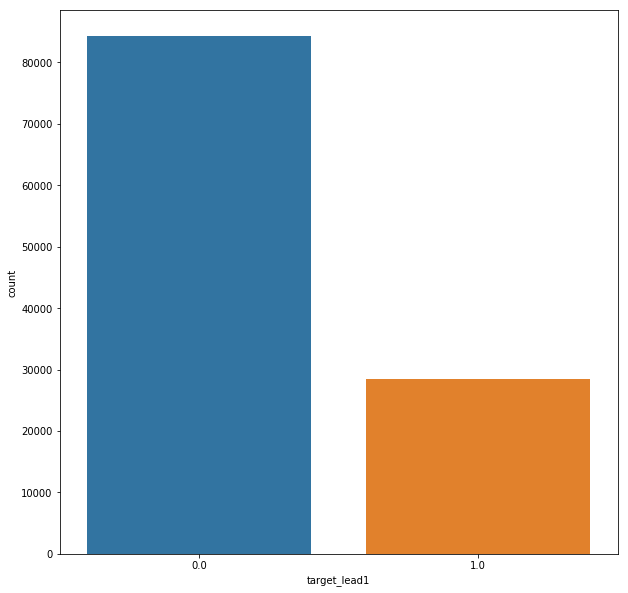

In [36]:
negative_class = data_['target_lead1'].value_counts(normalize = True)[0]
positive_class = data_['target_lead1'].value_counts(normalize = True)[1]
print(f'Observaciones de clase negativa: {round(negative_class * 100, 2)}%')
print(f'Observaciones de clase positiva: {round(positive_class * 100, 2)}%')
plt.figure(figsize = (10, 10))
sns.countplot(data_['target_lead1'])

No tendremos problema por un desbalance de clase, un 25.26% es bastante bueno. 

# Metrica de Evaluacion

No tengo conocimiento si los falsos positivos son peores o mas caros que los falsos negativos por lo tanto recomiendo utilizar la metrica F1 score la cual es la mediana harmonica entre "precision" y "recall"

Tambien se podria usar Roc Auc pero esa metrica esta orientada a problemas de ranking el cual no es nuestro caso

Por otro lado siempre hay que considerar el problema en si para diseñar una buena metrica de evaluacion, dado que no tengo mucho conocimiento de este usaremos F1

# Modelo

Utilizaremos Light GBM el cual da buenos resultados en este tipo de problemas, tambien se puede usar modelos estadisticos como arima, sarimax, prophet (de facebook) etc pero trataremos de armar una solucion mas orientada a machine learning

Este modelo maneja las variables categoricas (no es necesario realizar un "one hot encoding" y tambien se pueden pasar como argumento categoricas en una api) en lgb.Dataset(categorical_feature = [])

Los valores vacios tambien son tratados por el mismo modelo, por lo tanto no es necesario inputar. Logicamente tambien se puede imputar e incluso puede dar mejores resultados imputando, la experimentacion es la clave para encontrar el optimo.

Por ultimo la ingenieria de variables fue totalmente aleatoria (no se realizo una exploracion de datos en donde podemos determinar relaciones estadisticas entre las variables y el target), hay formas para encontrar buenos features pero se escapa del foco de este ejercicio

In [37]:
data_.head()

,nemotecnico_se,fecha,hora,gen_hidraulica_total_mwh,gen_solar_total_mwh,gen_termica_total_mwh,cmg_real,cmg_prog,cmg_desv,cmg_desv_pct,n_barras,demanda_mwh,cap_inst_mw,año,mes,semana_del_año,dia_calendario,dia_semana,flg_fds,target,en_total_mwh,nemotecnico_se_en,en_total_mwh_lag1,en_total_mwh_lag2,en_total_mwh_lag3,en_total_mwh_lag4,en_total_mwh_lag5,en_total_mwh_lag6,en_total_mwh_lag7,en_total_mwh_lag8,demanda_mwh_lag1,demanda_mwh_lag2,demanda_mwh_lag3,demanda_mwh_lag4,demanda_mwh_lag5,demanda_mwh_lag6,demanda_mwh_lag7,demanda_mwh_lag8,cmg_real_lag1,cmg_real_lag2,cmg_real_lag3,cmg_real_lag4,cmg_real_lag5,cmg_real_lag6,cmg_real_lag7,cmg_real_lag8,cmg_prog_lag1,cmg_prog_lag2,cmg_prog_lag3,cmg_prog_lag4,...,cmg_prog_16_min,cmg_prog_24_promedio,cmg_prog_24_std,cmg_prog_24_max,cmg_prog_24_min,cmg_prog_168_promedio,cmg_prog_168_std,cmg_prog_168_max,cmg_prog_168_min,cmg_desv_4_promedio,cmg_desv_4_std,cmg_desv_4_max,cmg_desv_4_min,cmg_desv_8_promedio,cmg_desv_8_std,cmg_desv_8_max,cmg_desv_8_min,cmg_desv_16_promedio,cmg_desv_16_std,cmg_desv_16_max,cmg_desv_16_min,cmg_desv_24_promedio,cmg_desv_24_std,cmg_desv_24_max,cmg_desv_24_min,cmg_desv_168_promedio,cmg_desv_168_std,cmg_desv_168_max,cmg_desv_168_min,cmg_desv_pct_4_promedio,cmg_desv_pct_4_std,cmg_desv_pct_4_max,cmg_desv_pct_4_min,cmg_desv_pct_8_promedio,cmg_desv_pct_8_std,cmg_desv_pct_8_max,cmg_desv_pct_8_min,cmg_desv_pct_16_promedio,cmg_desv_pct_16_std,cmg_desv_pct_16_max,cmg_desv_pct_16_min,cmg_desv_pct_24_promedio,cmg_desv_pct_24_std,cmg_desv_pct_24_max,cmg_desv_pct_24_min,cmg_desv_pct_168_promedio,cmg_desv_pct_168_std,cmg_desv_pct_168_max,cmg_desv_pct_168_min,target_lead1
0,SE001T002,2019-01-01 00:00:00+00:00,1,NaN,0.0,0.0,54.03,124.604410,-70.57,-56.64,2,61148556,14.2881,2019,1,1,1,1,0.0,1.0,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
1,SE001T002,2019-01-01 00:00:00+00:00,2,NaN,0.0,0.0,54.03,125.415516,-71.39,-56.92,2,136880002,14.2881,2019,1,1,1,1,0.0,1.0,0.0,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,61148556.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,54.03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,124.604410,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2,SE001T002,2019-01-01 00:00:00+00:00,3,NaN,0.0,0.0,54.03,52.383209,1.65,3.15,2,127833826,14.2881,2019,1,1,1,1,0.0,0.0,0.0,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,136880002.0,61148556.0,NaN,NaN,NaN,NaN,NaN,NaN,54.03,54.03,NaN,NaN,NaN,NaN,NaN,NaN,125.415516,124.604410,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
3,SE001T002,2019-01-01 00:00:00+00:00,4,NaN,0.0,0.0,54.03,53.482023,0.55,1.03,2,133924965,14.2881,2019,1,1,1,1,0.0,0.0,0.0,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,127833826.0,136880002.0,61148556.0,NaN,NaN,NaN,NaN,NaN,54.03,54.03,54.03,NaN,NaN,NaN,NaN,NaN,52.383209,125.415516,124.604410,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-34.940,41.619177,1.65,-71.39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-27.3450,33.99982,3.15,-56.92,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
4,SE001T002,2019-01-01 00:00:00+00:00,5,NaN,0.0,0.0,54.03,52.260469,1.77,3.39,2,138980453,14.2881,2019,1,1,1,1,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,133924965.0,127833826.0,136880002.0,61148556.0,NaN,NaN,NaN,NaN,54.03,54.03,54.03,54.03,NaN,NaN,NaN,NaN,53.482023,52.383209,125.415516,124.60441,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-16.855,36.360812,1.77,-71.39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-12.3375,29.74058,3

In [38]:
# Misma semilla para obtener resultados deterministicos
SEED = 42

def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    
seed_everything(SEED)

# Guardamos las variables con las cuales entrenaremos nuestro modelo
base_features = ['nemotecnico_se_en', 'hora', 'gen_hidraulica_total_mwh', 'gen_solar_total_mwh', 'gen_termica_total_mwh', 
                 'cmg_real', 'cmg_prog', 'cmg_desv', 'cmg_desv_pct', 'n_barras', 'demanda_mwh', 'cap_inst_mw', 
                 'mes', 'semana_del_año', 'dia_calendario', 'dia_semana', 'flg_fds', 'en_total_mwh']
eng_features = list(data_.columns[21:-1])
features = base_features + eng_features

# Variable a predecir
target = 'target_lead1'

# filtramos la primera semana de Enero debido a nuestros lags
data_ = data_[data_['fecha'] >= '2019-01-08']
data_.reset_index(inplace = True, drop = True)

# Particionamos nuestra data en base a la estrategia 1
train = data_[data_['fecha'] <= '2019-05-31']
validation = data_[(data_['fecha'] >= '2019-06-01') & (data_['fecha'] <= '2019-06-15')]
test = data_[data_['fecha'] >= '2019-06-16']

Training until validation scores don't improve for 50 rounds.
[100]	training's binary_logloss: 0.302369	valid_1's binary_logloss: 0.182197
[200]	training's binary_logloss: 0.20608	valid_1's binary_logloss: 0.126321
[300]	training's binary_logloss: 0.157059	valid_1's binary_logloss: 0.108936
[400]	training's binary_logloss: 0.126464	valid_1's binary_logloss: 0.102452
[500]	training's binary_logloss: 0.105176	valid_1's binary_logloss: 0.100569
[600]	training's binary_logloss: 0.0899333	valid_1's binary_logloss: 0.0995476
Early stopping, best iteration is:
[612]	training's binary_logloss: 0.0883474	valid_1's binary_logloss: 0.0995088
--------------------------------------------------


Nuestro mejor corte que maximiza el "F1 score" es 0.2181818181818182
Nuestro "F1 score" para la data de validacion es de 0.4863883847549909
Nuestro "F1 score" para la data de prueba es de 0.5756056808688389
--------------------------------------------------




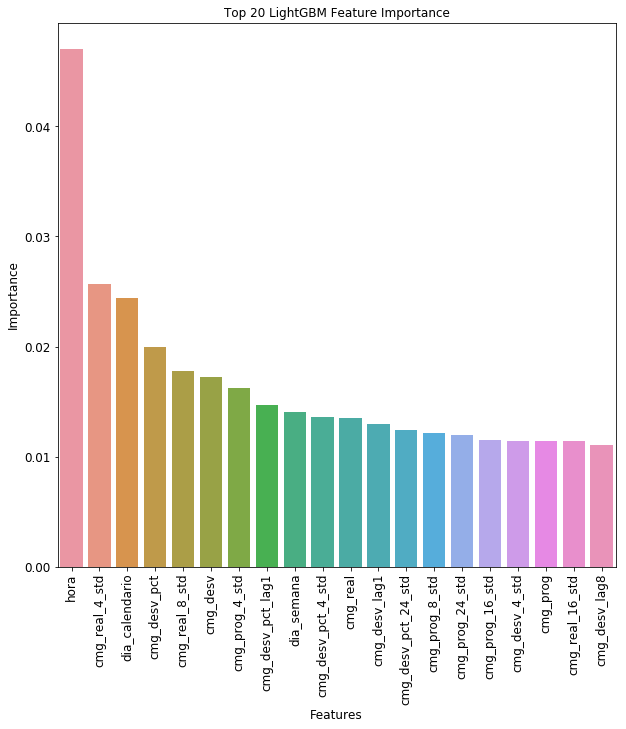

In [39]:
def run_simple_lgb(train, validation, test, features, target, params):
    
    x_train, x_val = train[features], validation[features]
    y_train, y_val = train[target], validation[target]
    train_set = lgb.Dataset(x_train, y_train)
    val_set = lgb.Dataset(x_val, y_val)
    
    def find_best_cut(model):
        oof_pred = model.predict(x_val)
        test_pred = model.predict(test[features])
        # Encontramos el mejor corte para maximizar nuestro "F1 score"
        cuts = np.linspace(0.1, 1, 100)
        best_f1 = 0
        best_cut = 0
        for cut in cuts:
            oof_pred_ = np.where(oof_pred >= cut, 1, 0)
            f1_ = metrics.f1_score(y_val, oof_pred_)
            if f1_ > best_f1:
                best_f1 = f1_
                best_cut = cut

        print('-'*50)
        print('\n')
        print(f'Nuestro mejor corte que maximiza el "F1 score" es {best_cut}')
        print(f'Nuestro "F1 score" para la data de validacion es de {best_f1}')

        test_pred = np.where(test_pred >= best_cut, 1, 0)
        test_f1 = metrics.f1_score(test[target], test_pred)
        print(f'Nuestro "F1 score" para la data de prueba es de {test_f1}')
        print('-'*50)
        print('\n')
        return test_f1

    model_gbdt = lgb.train(params, 
                           train_set, 
                           num_boost_round = 10000, 
                           early_stopping_rounds = 50, # Usamos early stopping con la data de validacion
                           valid_sets = [train_set, val_set], 
                           verbose_eval = 100)
    
    test_f1 = find_best_cut(model_gbdt)
    
    importance = model_gbdt.feature_importance()
    fe_importance = pd.DataFrame({'feature': features, 'importance': importance})
    fe_importance['importance_ratio'] = fe_importance['importance'] / fe_importance['importance'].sum()
    fe_importance.sort_values(['importance_ratio'], ascending = False, inplace = True)
    plt.figure(figsize = (10, 10))
    sns.barplot(x = fe_importance['feature'][:20], y = fe_importance['importance_ratio'][:20])
    plt.tick_params(axis = 'x', labelsize = 12, rotation = 90)
    plt.tick_params(axis = 'y', labelsize = 12)
    plt.xlabel('Features', fontsize = 12)
    plt.ylabel('Importance', fontsize = 12)
    plt.title('Top 20 LightGBM Feature Importance')
    plt.show()
    
    return test_f1, list(fe_importance['feature'][:20])
    

# Definimos nuestros hiperparametros (random, se podria optimizar utilizando gridsearh, random search, bayesian optimization)
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'n_jobs': -1, 
    'seed': SEED,
    'metric': 'binary_logloss',
    'num_leaves': 250, 
    'learning_rate': 0.01,  
    'bagging_fraction': 0.75, 
    'bagging_freq': 5, 
    'colsample_bytree': 0.75, 
    'colsample_bynode': 0.75,
    'lambda_l1': 0.5,
    'lambda_l2': 0.5}

test_f1, new_features = run_simple_lgb(train, validation, test, features, target, params)

En este caso podemos ver que los 5 features mas importantes son

* La hora
* La desviacion estandar movil de los ultimos cuatro periodos de la variable costo marginal real
* El dia del calendario
* El desviacion porcentual entre el costo marginal real y el costo marginal programado
* La desviacion estandar movil de los ultimos ocho periodos de la variable costo marginal real 

Veamos que sucede si entrenamos con los 20 features mas importantes y descartamos el resto

Training until validation scores don't improve for 50 rounds.
[100]	training's binary_logloss: 0.312207	valid_1's binary_logloss: 0.185588
[200]	training's binary_logloss: 0.219945	valid_1's binary_logloss: 0.129833
[300]	training's binary_logloss: 0.17282	valid_1's binary_logloss: 0.111189
[400]	training's binary_logloss: 0.143225	valid_1's binary_logloss: 0.103195
[500]	training's binary_logloss: 0.122035	valid_1's binary_logloss: 0.101107
[600]	training's binary_logloss: 0.105897	valid_1's binary_logloss: 0.100494
Early stopping, best iteration is:
[648]	training's binary_logloss: 0.0997512	valid_1's binary_logloss: 0.100287
--------------------------------------------------


Nuestro mejor corte que maximiza el "F1 score" es 0.24545454545454545
Nuestro "F1 score" para la data de validacion es de 0.45818181818181813
Nuestro "F1 score" para la data de prueba es de 0.5786758383490972
--------------------------------------------------




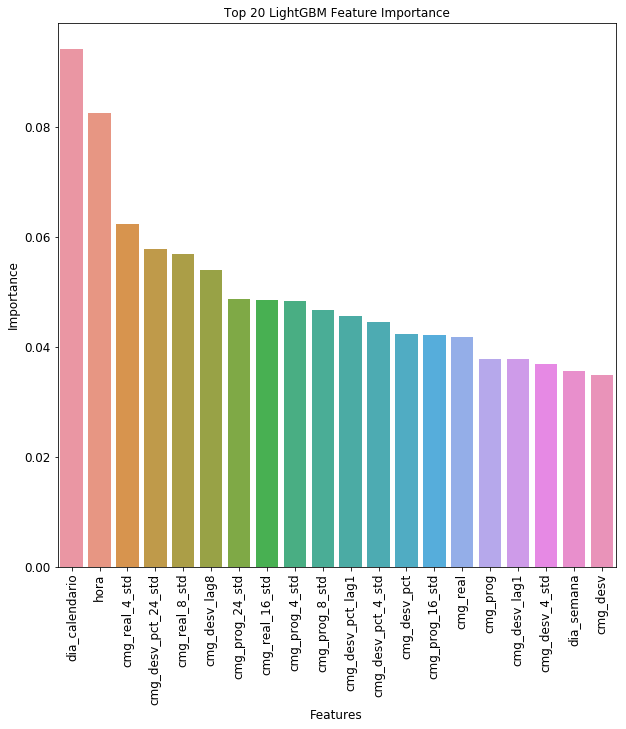

In [40]:
test_f1, new_features = run_simple_lgb(train, validation, test, new_features, target, params)

El segundo modelo con menos features logro obtener un mejor "F1 score" en el set de prueba, por otro lado en el set de validacion este obtuve un peor "F1 score". 

Ahora realizaremos un groupkfold por mes para validar el 100% de nuestra data y tener una metrica mas certera

Los feature mas importantes cambiaron pero de todas formas hora y dia_calendario son los primeros dos

Training fold 1
Validating with month 5
Training until validation scores don't improve for 50 rounds.
[100]	training's binary_logloss: 0.279252	valid_1's binary_logloss: 0.406375
[200]	training's binary_logloss: 0.182855	valid_1's binary_logloss: 0.370873
[300]	training's binary_logloss: 0.135135	valid_1's binary_logloss: 0.36328
Early stopping, best iteration is:
[301]	training's binary_logloss: 0.134758	valid_1's binary_logloss: 0.363247
--------------------------------------------------


Training fold 2
Validating with month 4
Training until validation scores don't improve for 50 rounds.
[100]	training's binary_logloss: 0.268662	valid_1's binary_logloss: 0.423048
[200]	training's binary_logloss: 0.176641	valid_1's binary_logloss: 0.381662
[300]	training's binary_logloss: 0.131215	valid_1's binary_logloss: 0.374565
Early stopping, best iteration is:
[345]	training's binary_logloss: 0.117197	valid_1's binary_logloss: 0.374352
--------------------------------------------------


Train

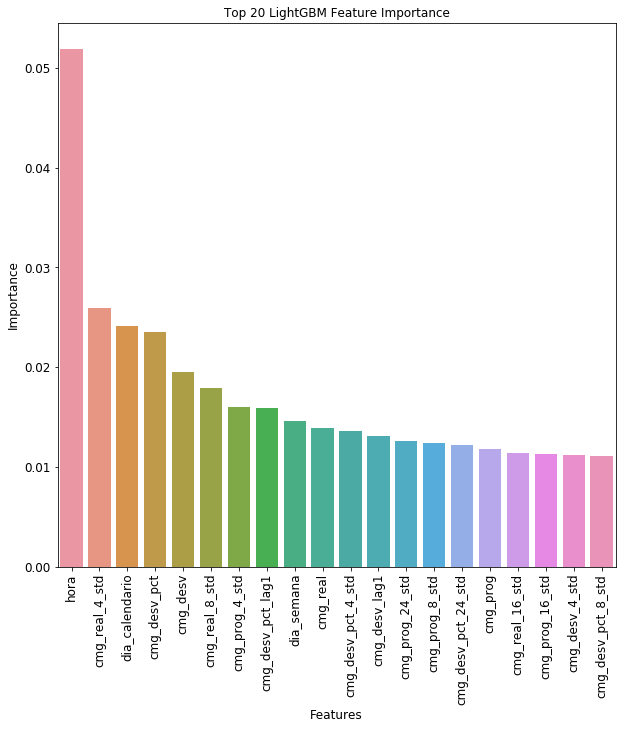

In [41]:
# Concatenamos la data de entrenamiento con la de validacion
train_ = pd.concat([train, validation], axis = 0)

def run_group_lgb(train, test, features, target, params, folds = 6):
    
    kfold = GroupKFold(n_splits = folds)
    oof_pred = np.zeros(len(train))
    test_pred = np.zeros(len(test))
    feature_importance = np.zeros(len(features))
    
    
    for fold, (trn_ind, val_ind) in enumerate(kfold.split(train[features], train[target], groups = train['mes'])):
        print(f'Training fold {fold + 1}')
        x_train, x_val = train.iloc[trn_ind][features], train.iloc[val_ind][features]
        y_train, y_val = train.iloc[trn_ind][target], train.iloc[val_ind][target]
        month = x_val['mes'].unique()[0]
        print(f'Validating with month {month}')
        train_set = lgb.Dataset(x_train, y_train)
        val_set = lgb.Dataset(x_val, y_val)
        
        model = lgb.train(params, 
                           train_set, 
                           num_boost_round = 10000, 
                           early_stopping_rounds = 50, # Usamos early stopping con la data de validacion
                           valid_sets = [train_set, val_set], 
                           verbose_eval = 100)
        
        oof_pred[val_ind] = model.predict(x_val)
        test_pred += model.predict(test[features]) / folds
        feature_importance += model.feature_importance() / folds
        print('-'*50)
        print('\n')
        
    
    # Encontramos el mejor corte para maximizar nuestro "F1 score"
    cuts = np.linspace(0.1, 1, 100)
    best_f1 = 0
    best_cut = 0
    for cut in cuts:
        oof_pred_ = np.where(oof_pred >= cut, 1, 0)
        f1_ = metrics.f1_score(train[target], oof_pred_)
        if f1_ > best_f1:
            best_f1 = f1_
            best_cut = cut

    print('-'*50)
    print('\n')
    print(f'Nuestro mejor corte que maximiza el "F1 score" es {best_cut}')
    print(f'Nuestro "F1 score" para nuestro "out of folds (toda la data de entrenamiento)" es de {best_f1}')

    test_pred = np.where(test_pred >= best_cut, 1, 0)
    test_f1 = metrics.f1_score(test[target], test_pred)
    print(f'Nuestro "F1 score" para la data de prueba es de {test_f1}')
    print('-'*50)
    print('\n')
    
    fe_importance = pd.DataFrame({'feature': features, 'importance': feature_importance})
    fe_importance['importance_ratio'] = fe_importance['importance'] / fe_importance['importance'].sum()
    fe_importance.sort_values(['importance_ratio'], ascending = False, inplace = True)
    plt.figure(figsize = (10, 10))
    sns.barplot(x = fe_importance['feature'][:20], y = fe_importance['importance_ratio'][:20])
    plt.tick_params(axis = 'x', labelsize = 12, rotation = 90)
    plt.tick_params(axis = 'y', labelsize = 12)
    plt.xlabel('Features', fontsize = 12)
    plt.ylabel('Importance', fontsize = 12)
    plt.title('Top 20 LightGBM Feature Importance')
    plt.show()
    
    return list(fe_importance['feature'][:20])

new_features_ = run_group_lgb(train_, test, features, target, params, folds = 6)

* Solo viendo el binary_logloss se puede ver que para cada fold las validaciones son distintas, por lo tanto un periodo de validacion no es confiable para medir el rendimiento del modelo

* Se puede ver una gran diferencia en el error de validacion en comparacion a los modelos anteriores

* Comparado con el modelo 1, el promedio de todos estos modelos tuvo un mejor rendimiento en el set de pruebas (modelo utilizando todos los features)

# 6.0 Prediccion de desviaciones del costo marginal: modelo 2

En el caso de que en produccion envien datos actualizados cada 12 horas (asumiendo que estamos hablando de el misma schema y estructura de datos) lo interpreto de la siguente manera

Si estamos parados en el momento t0, recien en t12 nos mandaran la data, en otras palabras en t0 deberiamos predecir t1, t2, t3 ... t10, t11, t12. Despues en t12 tenemos la data real de t1, t2, t3 ... t10, t11, t12 por lo tanto ahora podemos predecir t13, t14, t15 ... t22, t23, 24 y asi sucesivamente

Siguiendo la logica anterior esto se transforma en un problema multi label en donde tenemos que predecir 12 puntos

Hay varios modelos de sklearn que se pueden programar para predecir varios targets(normalmente para estos casos uso redes neuronales) pero dado que ya partimos con el modelo LightGradientBoosting haremos 12 modelos distintos (usando los mismos features) en donde cada uno prediga un periodo. Para agilizar el proceso no usaremos la estrategia de validacion por grupos si no que simplemente la primera estrategia que nombramos y tambien solo los 20 features mas importantes

Por ultimo como metrica de validacion usaremos el promedio de F1 score, en otras palabras (F1t1 + F1t2 + F1t3 + ... + F1t10 + F1t11 + F1t12) / 12

Training until validation scores don't improve for 50 rounds.
[100]	training's binary_logloss: 0.311937	valid_1's binary_logloss: 0.187072
[200]	training's binary_logloss: 0.219586	valid_1's binary_logloss: 0.130548
[300]	training's binary_logloss: 0.172772	valid_1's binary_logloss: 0.110956
[400]	training's binary_logloss: 0.143057	valid_1's binary_logloss: 0.103501
[500]	training's binary_logloss: 0.122144	valid_1's binary_logloss: 0.100993
[600]	training's binary_logloss: 0.106112	valid_1's binary_logloss: 0.101058
Early stopping, best iteration is:
[559]	training's binary_logloss: 0.112357	valid_1's binary_logloss: 0.100782
--------------------------------------------------


Nuestro mejor corte que maximiza el "F1 score" es 0.2181818181818182
Nuestro "F1 score" para la data de validacion es de 0.46308724832214765
Nuestro "F1 score" para la data de prueba es de 0.5812108559498956
--------------------------------------------------




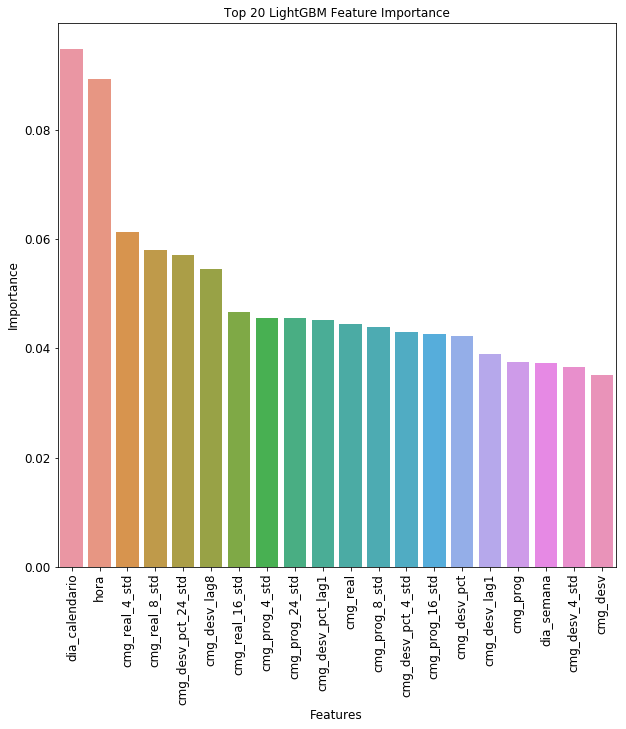

In [42]:
# Creamos una lista con los leads que faltan
leads = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
for lead in leads:
    data_[f'target_lead{lead}'] = data_.groupby(['nemotecnico_se'])['target'].transform(lambda x: x.shift(-lead))
    
# Eliminamos los valores vacios de los targets por el desplazamiento de la informacion
data_.dropna(subset = ['target_lead2', 'target_lead3', 'target_lead4', 'target_lead5', 'target_lead6', 'target_lead7', 
                       'target_lead8', 'target_lead9', 'target_lead10', 'target_lead11', 'target_lead12'], inplace = True)

data_.reset_index(inplace = True, drop = True)

# Particionamos nuevamente nuestra data en base a la estrategia 1
train = data_[data_['fecha'] <= '2019-05-31']
validation = data_[(data_['fecha'] >= '2019-06-01') & (data_['fecha'] <= '2019-06-15')]
test = data_[data_['fecha'] >= '2019-06-16']

# Ahora utilizamos las funciones anteriores para ejecutar los 12 modelos donde cada uno perdice 1 periodo
target = 'target_lead1'
test_lead1, new_features = run_simple_lgb(train, validation, test, new_features, target, params)

Training until validation scores don't improve for 50 rounds.
[100]	training's binary_logloss: 0.356418	valid_1's binary_logloss: 0.209338
[200]	training's binary_logloss: 0.266638	valid_1's binary_logloss: 0.161459
[300]	training's binary_logloss: 0.216826	valid_1's binary_logloss: 0.141478
[400]	training's binary_logloss: 0.182958	valid_1's binary_logloss: 0.133003
[500]	training's binary_logloss: 0.157897	valid_1's binary_logloss: 0.129412
[600]	training's binary_logloss: 0.139036	valid_1's binary_logloss: 0.128806
Early stopping, best iteration is:
[560]	training's binary_logloss: 0.146125	valid_1's binary_logloss: 0.128637
--------------------------------------------------


Nuestro mejor corte que maximiza el "F1 score" es 0.17272727272727273
Nuestro "F1 score" para la data de validacion es de 0.2222222222222222
Nuestro "F1 score" para la data de prueba es de 0.4015209125475285
--------------------------------------------------




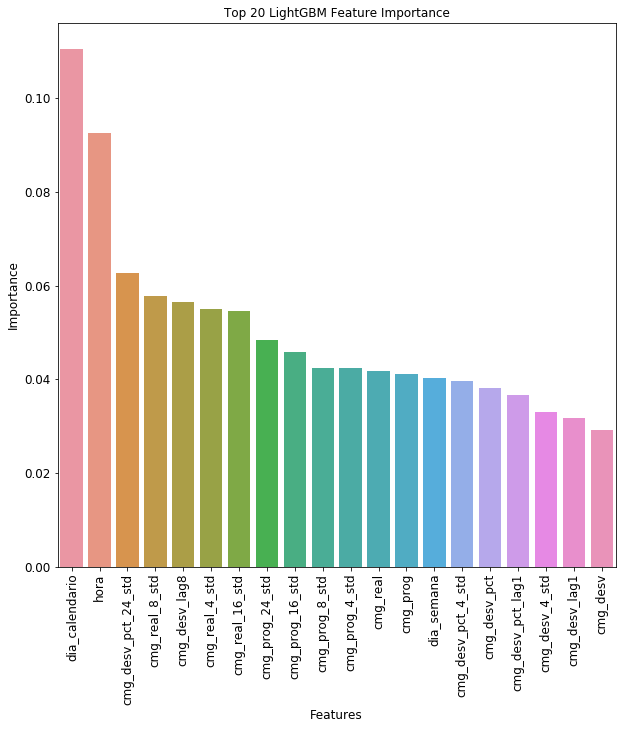

In [43]:
# Predecimos el periodo t2
target = 'target_lead2'
test_lead2, new_features = run_simple_lgb(train, validation, test, new_features, target, params)

Training until validation scores don't improve for 50 rounds.
[100]	training's binary_logloss: 0.376029	valid_1's binary_logloss: 0.23056
[200]	training's binary_logloss: 0.287722	valid_1's binary_logloss: 0.183859
[300]	training's binary_logloss: 0.236374	valid_1's binary_logloss: 0.162767
[400]	training's binary_logloss: 0.200511	valid_1's binary_logloss: 0.152221
[500]	training's binary_logloss: 0.174657	valid_1's binary_logloss: 0.14649
[600]	training's binary_logloss: 0.154575	valid_1's binary_logloss: 0.144828
[700]	training's binary_logloss: 0.139174	valid_1's binary_logloss: 0.144502
Early stopping, best iteration is:
[657]	training's binary_logloss: 0.145381	valid_1's binary_logloss: 0.144158
--------------------------------------------------


Nuestro mejor corte que maximiza el "F1 score" es 0.1090909090909091
Nuestro "F1 score" para la data de validacion es de 0.11247803163444638
Nuestro "F1 score" para la data de prueba es de 0.33900293255131964
---------------------------

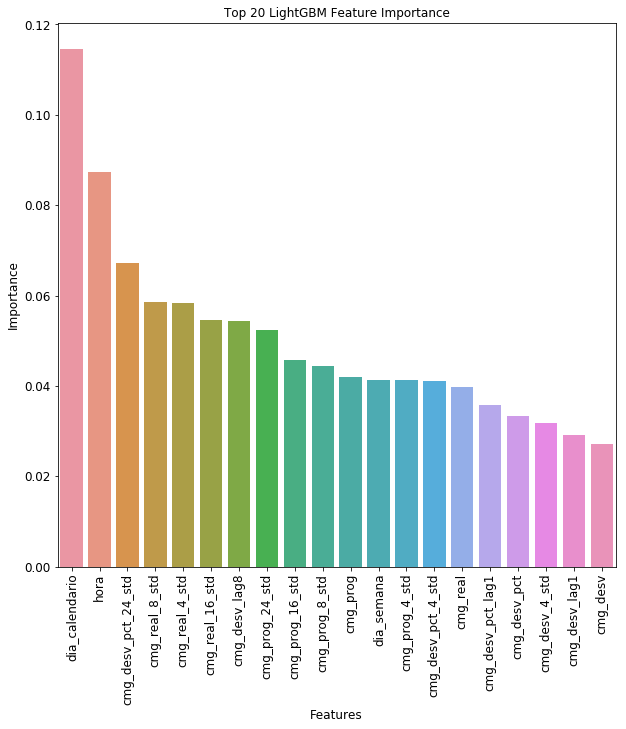

In [44]:
# Predecimos el periodo t3
target = 'target_lead3'
test_lead3, new_features = run_simple_lgb(train, validation, test, new_features, target, params)

Training until validation scores don't improve for 50 rounds.
[100]	training's binary_logloss: 0.39037	valid_1's binary_logloss: 0.242223
[200]	training's binary_logloss: 0.30273	valid_1's binary_logloss: 0.193491
[300]	training's binary_logloss: 0.248825	valid_1's binary_logloss: 0.172675
[400]	training's binary_logloss: 0.212322	valid_1's binary_logloss: 0.161201
[500]	training's binary_logloss: 0.185764	valid_1's binary_logloss: 0.154043
[600]	training's binary_logloss: 0.166136	valid_1's binary_logloss: 0.151297
[700]	training's binary_logloss: 0.150442	valid_1's binary_logloss: 0.149776
[800]	training's binary_logloss: 0.137343	valid_1's binary_logloss: 0.148242
Early stopping, best iteration is:
[829]	training's binary_logloss: 0.133817	valid_1's binary_logloss: 0.148049
--------------------------------------------------


Nuestro mejor corte que maximiza el "F1 score" es 0.1
Nuestro "F1 score" para la data de validacion es de 0.08297742525930446
Nuestro "F1 score" para la data d

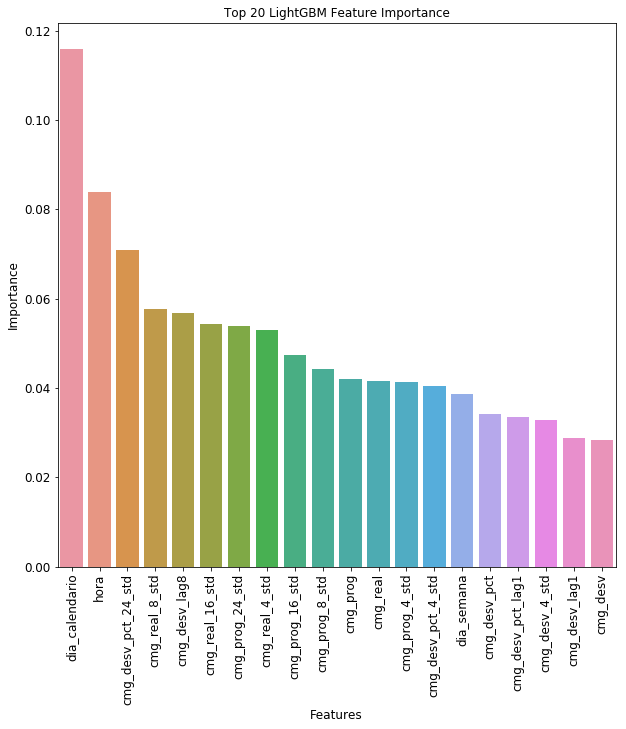

In [45]:
# Predecimos el periodo t4
target = 'target_lead4'
test_lead4, new_features = run_simple_lgb(train, validation, test, new_features, target, params)

Training until validation scores don't improve for 50 rounds.
[100]	training's binary_logloss: 0.395757	valid_1's binary_logloss: 0.242824
[200]	training's binary_logloss: 0.305697	valid_1's binary_logloss: 0.194334
[300]	training's binary_logloss: 0.252392	valid_1's binary_logloss: 0.170813
[400]	training's binary_logloss: 0.216456	valid_1's binary_logloss: 0.158562
[500]	training's binary_logloss: 0.190157	valid_1's binary_logloss: 0.151312
[600]	training's binary_logloss: 0.170414	valid_1's binary_logloss: 0.148971
[700]	training's binary_logloss: 0.154981	valid_1's binary_logloss: 0.147855
[800]	training's binary_logloss: 0.141687	valid_1's binary_logloss: 0.147271
Early stopping, best iteration is:
[750]	training's binary_logloss: 0.148057	valid_1's binary_logloss: 0.147183
--------------------------------------------------


Nuestro mejor corte que maximiza el "F1 score" es 0.1
Nuestro "F1 score" para la data de validacion es de 0.08809523809523809
Nuestro "F1 score" para la data

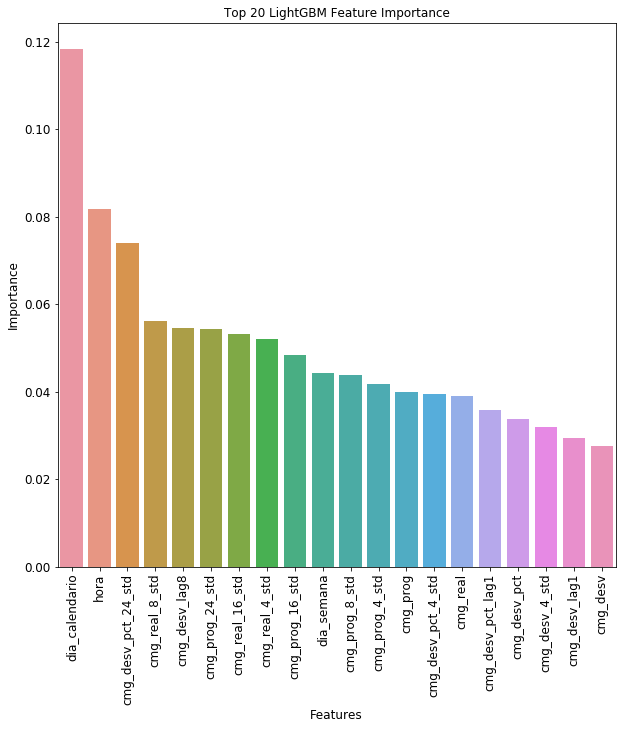

In [46]:
# Predecimos el periodo t5
target = 'target_lead5'
test_lead5, new_features = run_simple_lgb(train, validation, test, new_features, target, params)

Training until validation scores don't improve for 50 rounds.
[100]	training's binary_logloss: 0.394464	valid_1's binary_logloss: 0.250808
[200]	training's binary_logloss: 0.304976	valid_1's binary_logloss: 0.198806
[300]	training's binary_logloss: 0.252124	valid_1's binary_logloss: 0.17204
[400]	training's binary_logloss: 0.216572	valid_1's binary_logloss: 0.158227
[500]	training's binary_logloss: 0.19117	valid_1's binary_logloss: 0.151171
[600]	training's binary_logloss: 0.171373	valid_1's binary_logloss: 0.148587
[700]	training's binary_logloss: 0.155595	valid_1's binary_logloss: 0.146932
[800]	training's binary_logloss: 0.142402	valid_1's binary_logloss: 0.145568
Early stopping, best iteration is:
[809]	training's binary_logloss: 0.141303	valid_1's binary_logloss: 0.145385
--------------------------------------------------


Nuestro mejor corte que maximiza el "F1 score" es 0.1
Nuestro "F1 score" para la data de validacion es de 0.10844115834873691
Nuestro "F1 score" para la data d

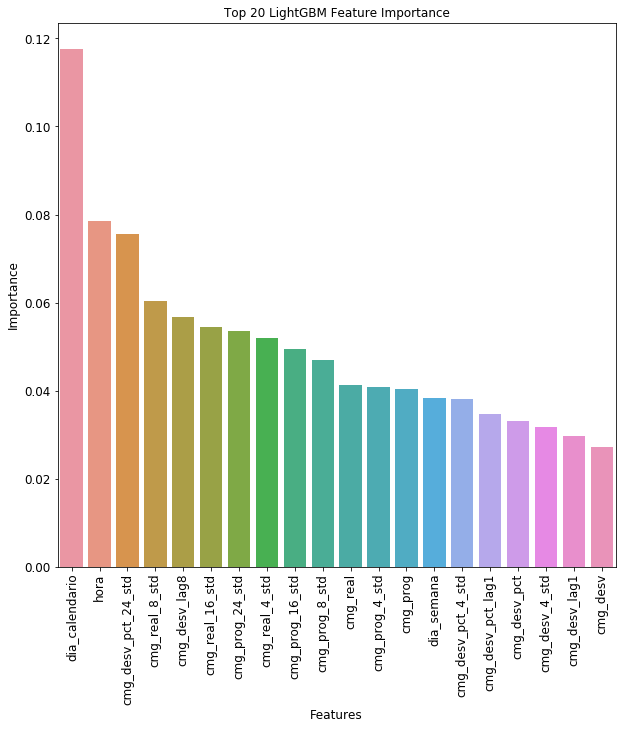

In [47]:
# Predecimos el periodo t6
target = 'target_lead6'
test_lead6, new_features = run_simple_lgb(train, validation, test, new_features, target, params)

Training until validation scores don't improve for 50 rounds.
[100]	training's binary_logloss: 0.394717	valid_1's binary_logloss: 0.246349
[200]	training's binary_logloss: 0.30492	valid_1's binary_logloss: 0.195318
[300]	training's binary_logloss: 0.252444	valid_1's binary_logloss: 0.170704
[400]	training's binary_logloss: 0.217536	valid_1's binary_logloss: 0.158771
[500]	training's binary_logloss: 0.192243	valid_1's binary_logloss: 0.152333
[600]	training's binary_logloss: 0.172654	valid_1's binary_logloss: 0.150092
[700]	training's binary_logloss: 0.157164	valid_1's binary_logloss: 0.148769
[800]	training's binary_logloss: 0.143784	valid_1's binary_logloss: 0.147822
[900]	training's binary_logloss: 0.132379	valid_1's binary_logloss: 0.147583
[1000]	training's binary_logloss: 0.122368	valid_1's binary_logloss: 0.147276
[1100]	training's binary_logloss: 0.11351	valid_1's binary_logloss: 0.146961
Early stopping, best iteration is:
[1111]	training's binary_logloss: 0.112488	valid_1's bin

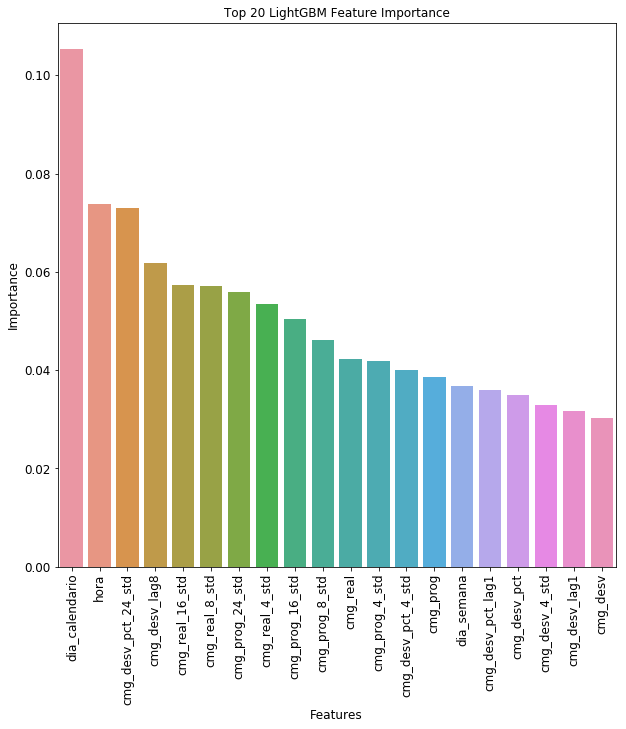

In [48]:
# Predecimos el periodo t7
target = 'target_lead7'
test_lead7, new_features = run_simple_lgb(train, validation, test, new_features, target, params)

Training until validation scores don't improve for 50 rounds.
[100]	training's binary_logloss: 0.394432	valid_1's binary_logloss: 0.247159
[200]	training's binary_logloss: 0.304057	valid_1's binary_logloss: 0.198389
[300]	training's binary_logloss: 0.25144	valid_1's binary_logloss: 0.170086
[400]	training's binary_logloss: 0.216718	valid_1's binary_logloss: 0.15806
[500]	training's binary_logloss: 0.191769	valid_1's binary_logloss: 0.151706
[600]	training's binary_logloss: 0.172129	valid_1's binary_logloss: 0.149715
[700]	training's binary_logloss: 0.15652	valid_1's binary_logloss: 0.148913
[800]	training's binary_logloss: 0.143297	valid_1's binary_logloss: 0.147982
[900]	training's binary_logloss: 0.131904	valid_1's binary_logloss: 0.147859
Early stopping, best iteration is:
[860]	training's binary_logloss: 0.136277	valid_1's binary_logloss: 0.147725
--------------------------------------------------


Nuestro mejor corte que maximiza el "F1 score" es 0.1
Nuestro "F1 score" para la da

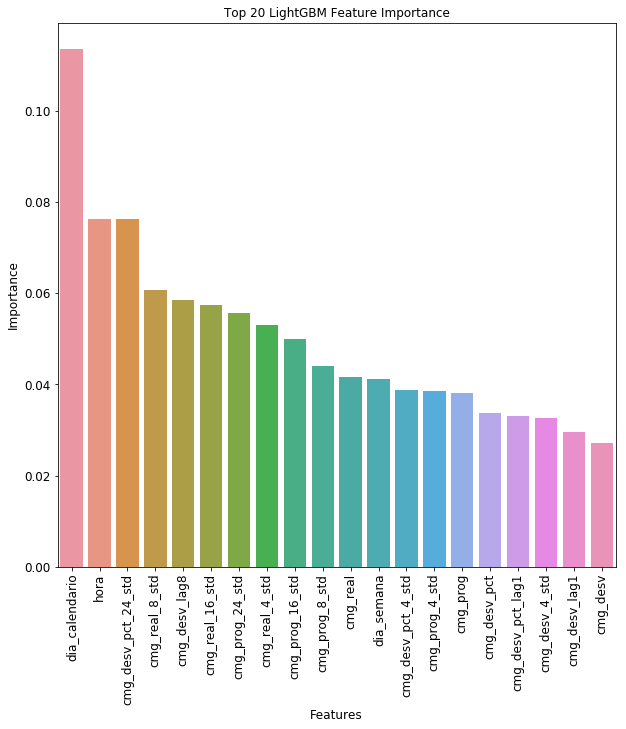

In [49]:
# Predecimos el periodo t8
target = 'target_lead8'
test_lead8, new_features = run_simple_lgb(train, validation, test, new_features, target, params)

Training until validation scores don't improve for 50 rounds.
[100]	training's binary_logloss: 0.393756	valid_1's binary_logloss: 0.244786
[200]	training's binary_logloss: 0.304342	valid_1's binary_logloss: 0.194557
[300]	training's binary_logloss: 0.252103	valid_1's binary_logloss: 0.167747
[400]	training's binary_logloss: 0.217139	valid_1's binary_logloss: 0.154867
[500]	training's binary_logloss: 0.191813	valid_1's binary_logloss: 0.147189
[600]	training's binary_logloss: 0.172337	valid_1's binary_logloss: 0.144073
[700]	training's binary_logloss: 0.156665	valid_1's binary_logloss: 0.142746
Early stopping, best iteration is:
[685]	training's binary_logloss: 0.158794	valid_1's binary_logloss: 0.142684
--------------------------------------------------


Nuestro mejor corte que maximiza el "F1 score" es 0.1
Nuestro "F1 score" para la data de validacion es de 0.12285012285012287
Nuestro "F1 score" para la data de prueba es de 0.28672000000000003
----------------------------------------

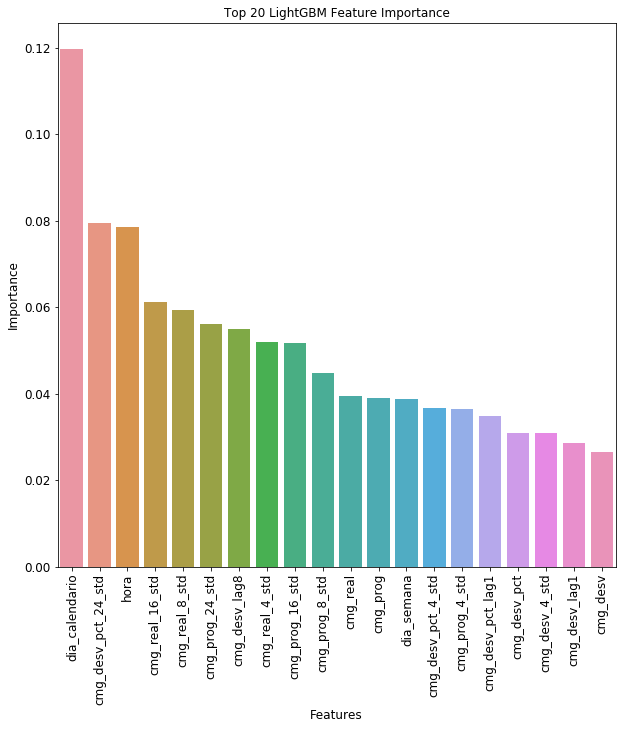

In [50]:
# Predecimos el periodo t9
target = 'target_lead9'
test_lead9, new_features = run_simple_lgb(train, validation, test, new_features, target, params)

Training until validation scores don't improve for 50 rounds.
[100]	training's binary_logloss: 0.396457	valid_1's binary_logloss: 0.24563
[200]	training's binary_logloss: 0.306851	valid_1's binary_logloss: 0.192366
[300]	training's binary_logloss: 0.253346	valid_1's binary_logloss: 0.165551
[400]	training's binary_logloss: 0.218666	valid_1's binary_logloss: 0.155002
[500]	training's binary_logloss: 0.19334	valid_1's binary_logloss: 0.147776
[600]	training's binary_logloss: 0.173465	valid_1's binary_logloss: 0.14523
[700]	training's binary_logloss: 0.157959	valid_1's binary_logloss: 0.143224
[800]	training's binary_logloss: 0.144364	valid_1's binary_logloss: 0.142589
Early stopping, best iteration is:
[780]	training's binary_logloss: 0.147095	valid_1's binary_logloss: 0.142332
--------------------------------------------------


Nuestro mejor corte que maximiza el "F1 score" es 0.1
Nuestro "F1 score" para la data de validacion es de 0.08828828828828829
Nuestro "F1 score" para la data de

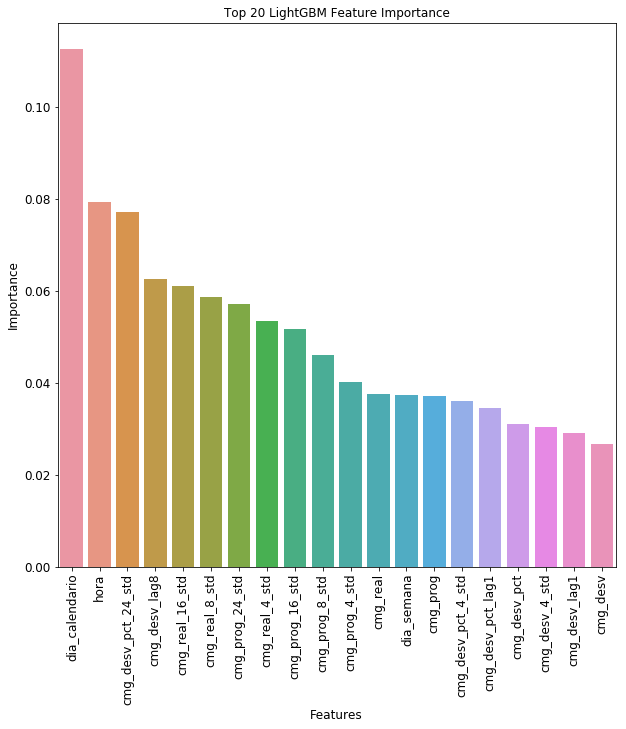

In [51]:
# Predecimos el periodo t10
target = 'target_lead10'
test_lead10, new_features = run_simple_lgb(train, validation, test, new_features, target, params)

Training until validation scores don't improve for 50 rounds.
[100]	training's binary_logloss: 0.396902	valid_1's binary_logloss: 0.247794
[200]	training's binary_logloss: 0.307126	valid_1's binary_logloss: 0.199476
[300]	training's binary_logloss: 0.254393	valid_1's binary_logloss: 0.174606
[400]	training's binary_logloss: 0.219264	valid_1's binary_logloss: 0.161587
[500]	training's binary_logloss: 0.193773	valid_1's binary_logloss: 0.151637
[600]	training's binary_logloss: 0.173697	valid_1's binary_logloss: 0.147206
[700]	training's binary_logloss: 0.1577	valid_1's binary_logloss: 0.144894
[800]	training's binary_logloss: 0.144222	valid_1's binary_logloss: 0.144315
[900]	training's binary_logloss: 0.132177	valid_1's binary_logloss: 0.143466
Early stopping, best iteration is:
[863]	training's binary_logloss: 0.136404	valid_1's binary_logloss: 0.143377
--------------------------------------------------


Nuestro mejor corte que maximiza el "F1 score" es 0.1
Nuestro "F1 score" para la d

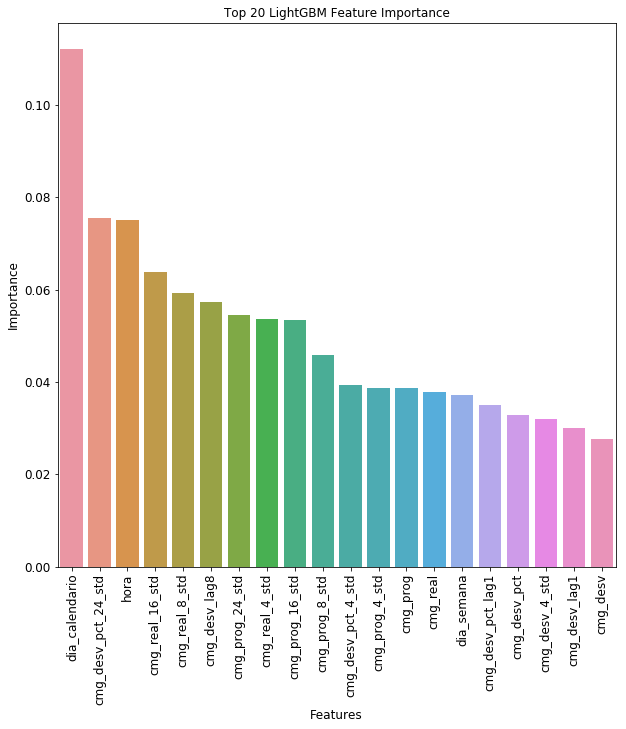

In [52]:
# Predecimos el periodo t11
target = 'target_lead11'
test_lead11, new_features = run_simple_lgb(train, validation, test, new_features, target, params)

Training until validation scores don't improve for 50 rounds.
[100]	training's binary_logloss: 0.398791	valid_1's binary_logloss: 0.248606
[200]	training's binary_logloss: 0.309607	valid_1's binary_logloss: 0.201051
[300]	training's binary_logloss: 0.257172	valid_1's binary_logloss: 0.178503
[400]	training's binary_logloss: 0.221723	valid_1's binary_logloss: 0.16197
[500]	training's binary_logloss: 0.195848	valid_1's binary_logloss: 0.155079
[600]	training's binary_logloss: 0.176132	valid_1's binary_logloss: 0.151114
[700]	training's binary_logloss: 0.160258	valid_1's binary_logloss: 0.14864
[800]	training's binary_logloss: 0.146341	valid_1's binary_logloss: 0.147563
Early stopping, best iteration is:
[805]	training's binary_logloss: 0.145653	valid_1's binary_logloss: 0.147075
--------------------------------------------------


Nuestro mejor corte que maximiza el "F1 score" es 0.1
Nuestro "F1 score" para la data de validacion es de 0.05300713557594292
Nuestro "F1 score" para la data d

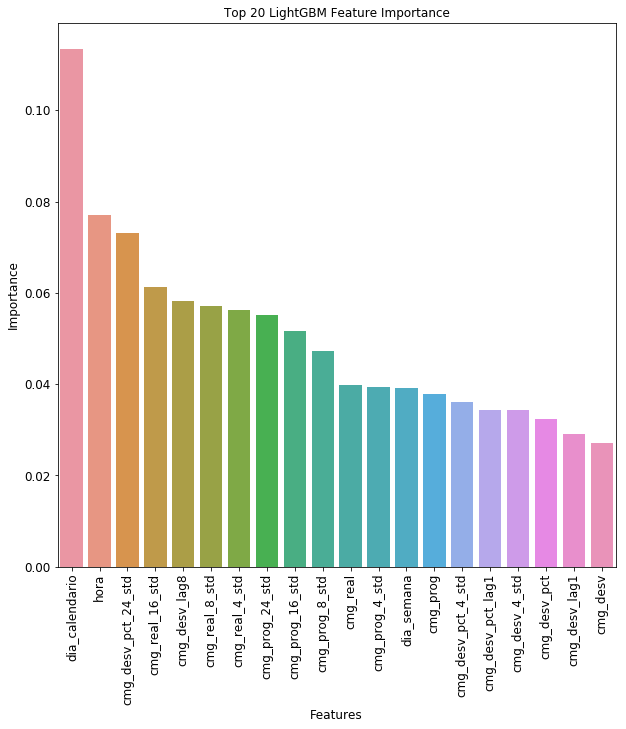

In [53]:
# Predecimos el periodo t12
target = 'target_lead12'
test_lead12, new_features = run_simple_lgb(train, validation, test, new_features, target, params)

In [54]:
f1_score_list = [test_lead1, test_lead2, test_lead3, test_lead4, test_lead5, test_lead6, test_lead7, test_lead8, test_lead9, 
                 test_lead10, test_lead11, test_lead12]
f1_final_score = np.average(f1_score_list)
print(f'Nuestro "F1 score" promedio para los 12 periodos es de {f1_final_score}')

Nuestro "F1 score" promedio para los 12 periodos es de 0.2861174450161882


A diferencia del modelo uno el error de este va aumentado a medida que aumenta la ventana, en cierto sentido esto es muy comun en series de tiempo dado que los lags son muy buenos predictores.

Por este misma razon el "F1 score" es mas bajo.

# 7.0 Merge con datos de clima: Modelo 3

En esta etapa incluiremos los datos de clima y entrenaremos nuevamente nuestros modelos

In [55]:
climate = read_dataset('datos_clima.csv', 'datos del clima')
climate.head()

Nuestro dataset datos del clima tiene 5249 filas y 20 columnas
Nuestro dataset datos del clima tiene 5249 filas y 20 columnas despues de eliminar las filas duplicadas


,fecha,subestacion,lat,lon,ALLSKY_SFC_SW_DWN,KT,PRECTOT,RH2M,T2M,T2MDEW,T2M_MAX,T2M_MIN,TQV,TS,WS10M,WS10M_MAX,WS10M_MIN,WS50M,WS50M_MAX,WS50M_MIN
0,2019-05-06 00:00:00 UTC,SE019T002,-28.470641,-71.252694,2.0,0.31,0.00,74.66,16.39,11.94,19.01,13.93,1.78,16.62,4.14,4.93,2.81,5.01,6.23,3.50
1,2019-05-21 00:00:00 UTC,SE005T003,-42.626987,-73.805673,2.0,0.54,0.01,92.82,5.55,4.45,9.39,3.32,0.77,6.50,2.64,2.94,2.04,4.20,4.94,3.55
2,2019-02-28 00:00:00 UTC,SE005T003,-42.626987,-73.805673,2.0,0.21,2.35,88.87,12.25,10.45,15.64,9.61,2.34,12.44,2.62,3.77,1.78,4.16,5.68,2.85
3,2019-01-08 00:00:00 UTC,SE004T002,-39.549899,-72.912208,2.0,0.16,5.96,92.22,9.52,8.30,10.88,7.90,1.62,10.17,2.70,4.02,1.67,4.96,6.87,2.97
4,2019-05-07 00:00:00 UTC,SE003T011,-35.685919,-71.377335,2.0,0.37,0.00,44.02,13.57,1.49,20.38,9.57,1.05,11.34,1.69,3.58,0.65,2.25,4.42,0.96


In [56]:
# Transformemos la columna fecha a datetime
climate['fecha'] = pd.to_datetime(climate['fecha'])

# Creemos una copia de nuestra data anterios
climate_data = data_.copy()

# Unamos la tabla del clima con nuestra tabla anterior
climate_data = climate_data.merge(climate, how = 'left', left_on = ['fecha', 'nemotecnico_se'], right_on = ['fecha', 'subestacion'])

# Particionamos nuevamente nuestra data en base a la estrategia 1
train = climate_data[climate_data['fecha'] <= '2019-05-31']
validation = climate_data[(climate_data['fecha'] >= '2019-06-01') & (climate_data['fecha'] <= '2019-06-15')]
test = climate_data[climate_data['fecha'] >= '2019-06-16']
train.head()

,nemotecnico_se,fecha,hora,gen_hidraulica_total_mwh,gen_solar_total_mwh,gen_termica_total_mwh,cmg_real,cmg_prog,cmg_desv,cmg_desv_pct,n_barras,demanda_mwh,cap_inst_mw,año,mes,semana_del_año,dia_calendario,dia_semana,flg_fds,target,en_total_mwh,nemotecnico_se_en,en_total_mwh_lag1,en_total_mwh_lag2,en_total_mwh_lag3,en_total_mwh_lag4,en_total_mwh_lag5,en_total_mwh_lag6,en_total_mwh_lag7,en_total_mwh_lag8,demanda_mwh_lag1,demanda_mwh_lag2,demanda_mwh_lag3,demanda_mwh_lag4,demanda_mwh_lag5,demanda_mwh_lag6,demanda_mwh_lag7,demanda_mwh_lag8,cmg_real_lag1,cmg_real_lag2,cmg_real_lag3,cmg_real_lag4,cmg_real_lag5,cmg_real_lag6,cmg_real_lag7,cmg_real_lag8,cmg_prog_lag1,cmg_prog_lag2,cmg_prog_lag3,cmg_prog_lag4,...,cmg_desv_pct_4_std,cmg_desv_pct_4_max,cmg_desv_pct_4_min,cmg_desv_pct_8_promedio,cmg_desv_pct_8_std,cmg_desv_pct_8_max,cmg_desv_pct_8_min,cmg_desv_pct_16_promedio,cmg_desv_pct_16_std,cmg_desv_pct_16_max,cmg_desv_pct_16_min,cmg_desv_pct_24_promedio,cmg_desv_pct_24_std,cmg_desv_pct_24_max,cmg_desv_pct_24_min,cmg_desv_pct_168_promedio,cmg_desv_pct_168_std,cmg_desv_pct_168_max,cmg_desv_pct_168_min,target_lead1,target_lead2,target_lead3,target_lead4,target_lead5,target_lead6,target_lead7,target_lead8,target_lead9,target_lead10,target_lead11,target_lead12,subestacion,lat,lon,ALLSKY_SFC_SW_DWN,KT,PRECTOT,RH2M,T2M,T2MDEW,T2M_MAX,T2M_MIN,TQV,TS,WS10M,WS10M_MAX,WS10M_MIN,WS50M,WS50M_MAX,WS50M_MIN
0,SE001T002,2019-01-08 00:00:00+00:00,1,NaN,0.0,0.0,53.75,56.965158,-3.22,-5.65,2,134595835,14.2881,2019,1,2,8,1,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.01,0.12,0.19,0.22,61311294.0,136835927.0,134809122.0,132799529.0,133477667.0,136284301.0,127877250.0,125371560.0,52.41,52.41,52.41,52.41,50.22,46.82,43.09,43.09,88.387739,104.682702,169.894814,53.525152,...,26.591700,-5.65,-69.15,-21.53250,27.514835,1.54,-69.15,-13.441875,20.596140,1.54,-69.15,-9.952083,17.548542,4.54,-69.15,-12.840000,24.106121,49.67,-99.99,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,SE001T002,-27.487872,-70.38801,9.12,0.76,0.0,47.44,18.18,6.81,25.09,12.42,1.17,22.74,3.14,6.33,0.19,2.86,5.3,0.12
1,SE001T002,2019-01-08 00:00:00+00:00,2,NaN,0.0,0.0,53.75,54.724744,-0.97,-1.77,2,136751250,14.2881,2019,1,2,8,1,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.00,0.01,0.12,0.19,134595835.0,61311294.0,136835927.0,134809122.0,132799529.0,133477667.0,136284301.0,127877250.0,53.75,52.41,52.41,52.41,52.41,50.22,46.82,43.09,56.965158,88.387739,104.682702,169.894814,...,24.368173,-1.77,-49.93,-20.98375,27.906212,1.54,-69.15,-13.447500,20.592725,1.54,-69.15,-9.995833,17.525819,4.54,-69.15,-12.511726,23.876672,49.67,-99.99,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,SE001T002,-27.487872,-70.38801,9.12,0.76,0.0,47.44,18.18,6.81,25.09,12.42,1.17,22.74,3.14,6.33,0.19,2.86,5.3,0.12
2,SE001T002,2019-01-08 00:00:00+00:00,3,NaN,0.0,0.0,53.75,52.655862,1.09,2.07,2,138741908,14.2881,2019,1,2,8,1,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.00,0.00,0.01,0.12,136751250.0,134595835.0,61311294.0,136835927.0,134809122.0,132799529.0,133477667.0,136284301.0,53.75,53.75,52.41,52.41,52.41,52.41,50.22,46.82,54.724744,56.965158,88.387739,104.682702,...,19.716858,2.07,-40.71,-20.71125,28.148749,2.07,-69.15,-12.985000,20.868448,2.07,-69.15,-9.605000,17.692119,4.54,-69.15,-12.518155,23.872575,49.67,-99.99,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,SE001T002,-27.487872,-70.38801,9.12,0.76,0.0,47.44,18.18,6.81,25.09,12.42,1.17,22.74,3.14,6.33,0.19,2.86,5.3,0.12
3,SE001T002,2019-01-08 00:00:00+00:00,4,NaN,0.0,0.0,53.75,52.547490,1.20,2.28,2,138495732,14.2881,2019,1,2,8,1,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.01,138741908.0,136751250.0,134595835.0,61311294.0,136835927.0,134809122.0,132799529.0,133477667.0,53.75,53.75,53.75,52.41,52.41,52.41,52.41,50.22,52.655862,54.724744,56.965158,88.387739,...,3.749777,2.28,-5.65,-20.61875,28.233403,2.28,-69.15,-12.506250,21.140638,2.28,-69.15,-9.155417,17.857477,4.54,-69.15,-12.510714,23.877017,49.67,-99.99,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,SE001T002,-27.487872,-70.38801,9.12,0.76,0.

In [57]:
# Revisamos si existen valores vacion (nulos) en nuestro nuevo dataset
climate_data.isnull().sum()

nemotecnico_se                   0
fecha                            0
hora                             0
gen_hidraulica_total_mwh     75370
gen_solar_total_mwh          67930
gen_termica_total_mwh        48770
cmg_real                         0
cmg_prog                         0
cmg_desv                         0
cmg_desv_pct                     0
n_barras                         0
demanda_mwh                      0
cap_inst_mw                      0
año                              0
mes                              0
semana_del_año                   0
dia_calendario                   0
dia_semana                       0
flg_fds                          0
target                           0
en_total_mwh                     0
nemotecnico_se_en                0
en_total_mwh_lag1                2
en_total_mwh_lag2                4
en_total_mwh_lag3                6
en_total_mwh_lag4                8
en_total_mwh_lag5               10
en_total_mwh_lag6               12
en_total_mwh_lag7   

No existen valores nulos. 

Training until validation scores don't improve for 50 rounds.
[100]	training's binary_logloss: 0.312261	valid_1's binary_logloss: 0.18816
[200]	training's binary_logloss: 0.219876	valid_1's binary_logloss: 0.133261
[300]	training's binary_logloss: 0.172798	valid_1's binary_logloss: 0.113902
[400]	training's binary_logloss: 0.143219	valid_1's binary_logloss: 0.105825
[500]	training's binary_logloss: 0.122395	valid_1's binary_logloss: 0.103167
[600]	training's binary_logloss: 0.106977	valid_1's binary_logloss: 0.102619
[700]	training's binary_logloss: 0.0948854	valid_1's binary_logloss: 0.102315
Early stopping, best iteration is:
[663]	training's binary_logloss: 0.099139	valid_1's binary_logloss: 0.102223
--------------------------------------------------


Nuestro mejor corte que maximiza el "F1 score" es 0.19090909090909092
Nuestro "F1 score" para la data de validacion es de 0.4504201680672269
Nuestro "F1 score" para la data de prueba es de 0.5692913385826771
--------------------------

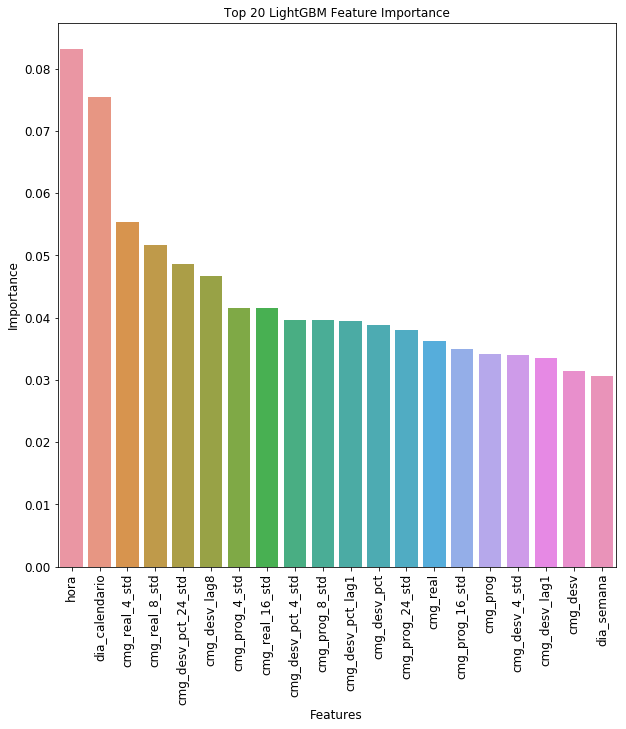

In [58]:
# Utilizamos los 20 mejores features de nuestro modelo anterior mas los features del clima
climate_features = new_features + list(climate_data.columns[203:])

# Predecimos el periodo t1 incluyendo los features de clima
target = 'target_lead1'
test_lead1, new_features = run_simple_lgb(train, validation, test, climate_features, target, params)

Training until validation scores don't improve for 50 rounds.
[100]	training's binary_logloss: 0.354924	valid_1's binary_logloss: 0.212446
[200]	training's binary_logloss: 0.264831	valid_1's binary_logloss: 0.164881
[300]	training's binary_logloss: 0.215181	valid_1's binary_logloss: 0.142587
[400]	training's binary_logloss: 0.181461	valid_1's binary_logloss: 0.130456
[500]	training's binary_logloss: 0.156571	valid_1's binary_logloss: 0.125662
[600]	training's binary_logloss: 0.139046	valid_1's binary_logloss: 0.125118
[700]	training's binary_logloss: 0.124585	valid_1's binary_logloss: 0.124903
Early stopping, best iteration is:
[705]	training's binary_logloss: 0.123874	valid_1's binary_logloss: 0.124775
--------------------------------------------------


Nuestro mejor corte que maximiza el "F1 score" es 0.17272727272727273
Nuestro "F1 score" para la data de validacion es de 0.2491349480968858
Nuestro "F1 score" para la data de prueba es de 0.4156988386063276
--------------------------

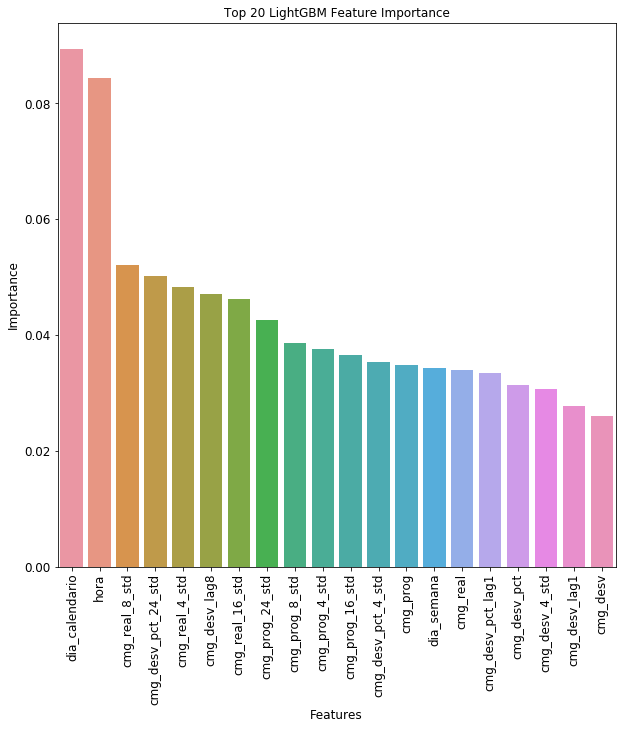

In [59]:
# Predecimos el periodo t2 incluyendo los features de clima
target = 'target_lead2'
test_lead2, new_features = run_simple_lgb(train, validation, test, climate_features, target, params)

Training until validation scores don't improve for 50 rounds.
[100]	training's binary_logloss: 0.37437	valid_1's binary_logloss: 0.230487
[200]	training's binary_logloss: 0.284162	valid_1's binary_logloss: 0.183155
[300]	training's binary_logloss: 0.232284	valid_1's binary_logloss: 0.160212
[400]	training's binary_logloss: 0.196555	valid_1's binary_logloss: 0.148354
[500]	training's binary_logloss: 0.170846	valid_1's binary_logloss: 0.141412
[600]	training's binary_logloss: 0.151691	valid_1's binary_logloss: 0.139486
[700]	training's binary_logloss: 0.13622	valid_1's binary_logloss: 0.139154
Early stopping, best iteration is:
[725]	training's binary_logloss: 0.13288	valid_1's binary_logloss: 0.138447
--------------------------------------------------


Nuestro mejor corte que maximiza el "F1 score" es 0.1
Nuestro "F1 score" para la data de validacion es de 0.12629757785467127
Nuestro "F1 score" para la data de prueba es de 0.3420165491878639
--------------------------------------------

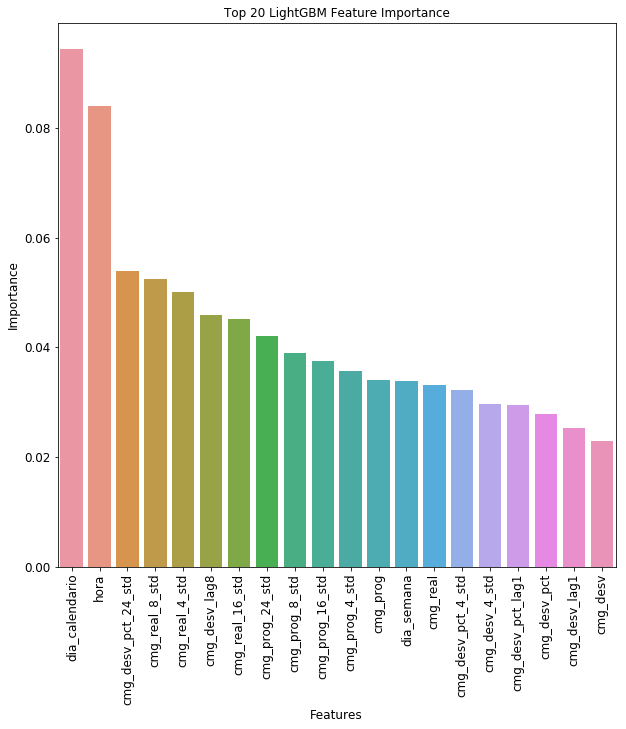

In [60]:
# Predecimos el periodo t3 incluyendo los features de clima
target = 'target_lead3'
test_lead3, new_features = run_simple_lgb(train, validation, test, climate_features, target, params)

Training until validation scores don't improve for 50 rounds.
[100]	training's binary_logloss: 0.387741	valid_1's binary_logloss: 0.239656
[200]	training's binary_logloss: 0.298522	valid_1's binary_logloss: 0.191512
[300]	training's binary_logloss: 0.243296	valid_1's binary_logloss: 0.168228
[400]	training's binary_logloss: 0.20714	valid_1's binary_logloss: 0.154785
[500]	training's binary_logloss: 0.181233	valid_1's binary_logloss: 0.147867
[600]	training's binary_logloss: 0.161494	valid_1's binary_logloss: 0.145341
[700]	training's binary_logloss: 0.145796	valid_1's binary_logloss: 0.144495
Early stopping, best iteration is:
[678]	training's binary_logloss: 0.149078	valid_1's binary_logloss: 0.144201
--------------------------------------------------


Nuestro mejor corte que maximiza el "F1 score" es 0.1181818181818182
Nuestro "F1 score" para la data de validacion es de 0.09767441860465115
Nuestro "F1 score" para la data de prueba es de 0.20785070785070786
--------------------------

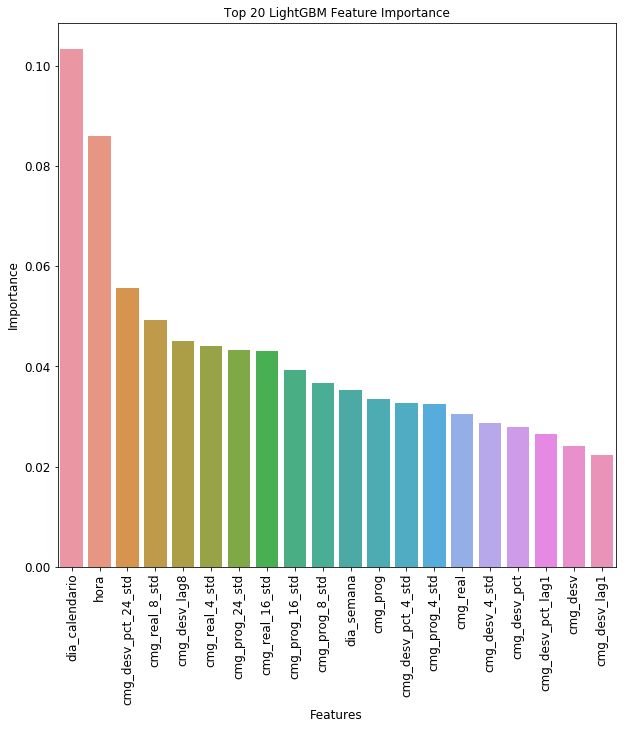

In [61]:
# Predecimos el periodo t4 incluyendo los features de clima
target = 'target_lead4'
test_lead4, new_features = run_simple_lgb(train, validation, test, climate_features, target, params)

Training until validation scores don't improve for 50 rounds.
[100]	training's binary_logloss: 0.390722	valid_1's binary_logloss: 0.242278
[200]	training's binary_logloss: 0.298815	valid_1's binary_logloss: 0.191662
[300]	training's binary_logloss: 0.246129	valid_1's binary_logloss: 0.167784
[400]	training's binary_logloss: 0.210003	valid_1's binary_logloss: 0.15273
[500]	training's binary_logloss: 0.183924	valid_1's binary_logloss: 0.147044
[600]	training's binary_logloss: 0.16522	valid_1's binary_logloss: 0.144019
[700]	training's binary_logloss: 0.149032	valid_1's binary_logloss: 0.142357
[800]	training's binary_logloss: 0.135751	valid_1's binary_logloss: 0.141084
[900]	training's binary_logloss: 0.124175	valid_1's binary_logloss: 0.140398
[1000]	training's binary_logloss: 0.114299	valid_1's binary_logloss: 0.139525
[1100]	training's binary_logloss: 0.105188	valid_1's binary_logloss: 0.138728
Early stopping, best iteration is:
[1122]	training's binary_logloss: 0.10343	valid_1's bina

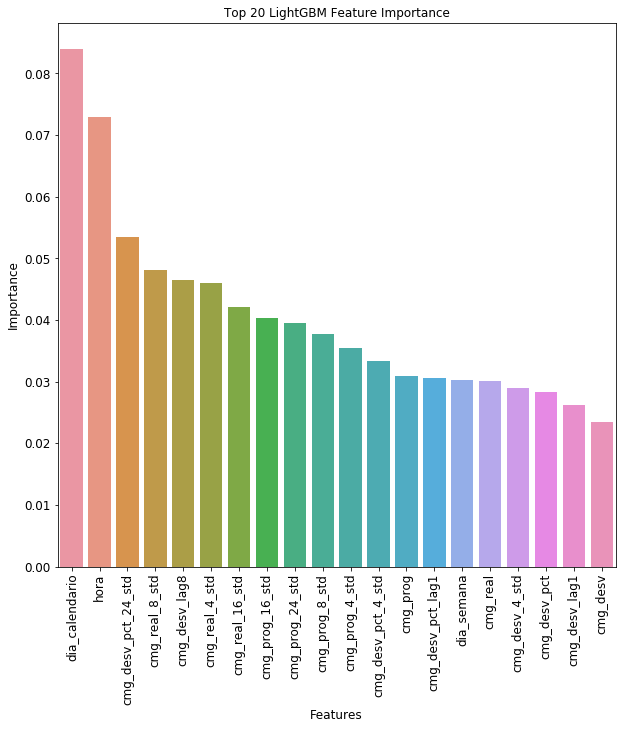

In [62]:
# Predecimos el periodo t5 incluyendo los features de clima
target = 'target_lead5'
test_lead5, new_features = run_simple_lgb(train, validation, test, climate_features, target, params)

Training until validation scores don't improve for 50 rounds.
[100]	training's binary_logloss: 0.388183	valid_1's binary_logloss: 0.244464
[200]	training's binary_logloss: 0.297004	valid_1's binary_logloss: 0.193922
[300]	training's binary_logloss: 0.245025	valid_1's binary_logloss: 0.168205
[400]	training's binary_logloss: 0.209323	valid_1's binary_logloss: 0.154009
[500]	training's binary_logloss: 0.183933	valid_1's binary_logloss: 0.147247
[600]	training's binary_logloss: 0.164465	valid_1's binary_logloss: 0.144343
[700]	training's binary_logloss: 0.148125	valid_1's binary_logloss: 0.14293
[800]	training's binary_logloss: 0.134775	valid_1's binary_logloss: 0.141908
[900]	training's binary_logloss: 0.123292	valid_1's binary_logloss: 0.141349
[1000]	training's binary_logloss: 0.113053	valid_1's binary_logloss: 0.140392
[1100]	training's binary_logloss: 0.103858	valid_1's binary_logloss: 0.14003
Early stopping, best iteration is:
[1064]	training's binary_logloss: 0.106978	valid_1's bin

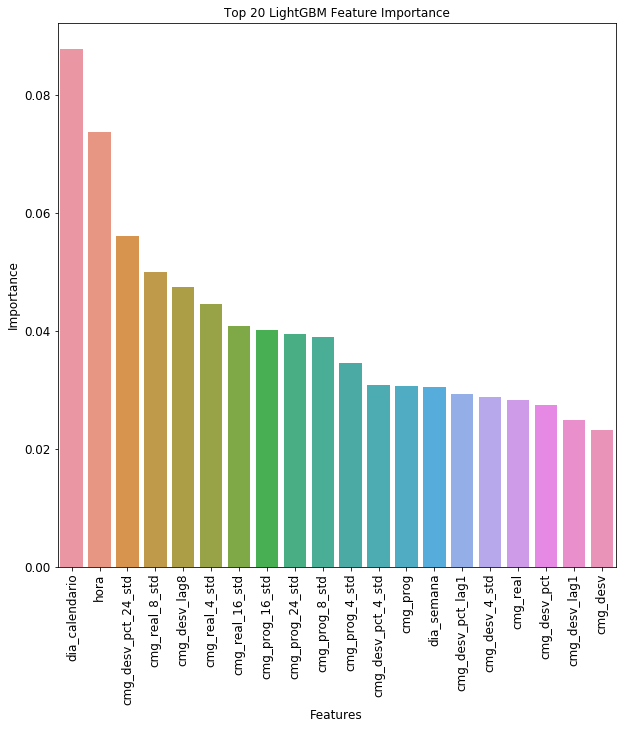

In [63]:
# Predecimos el periodo t6 incluyendo los features de clima
target = 'target_lead6'
test_lead6, new_features = run_simple_lgb(train, validation, test, climate_features, target, params)

Training until validation scores don't improve for 50 rounds.
[100]	training's binary_logloss: 0.38902	valid_1's binary_logloss: 0.245016
[200]	training's binary_logloss: 0.2983	valid_1's binary_logloss: 0.197129
[300]	training's binary_logloss: 0.244689	valid_1's binary_logloss: 0.174343
[400]	training's binary_logloss: 0.209525	valid_1's binary_logloss: 0.158977
[500]	training's binary_logloss: 0.183662	valid_1's binary_logloss: 0.151855
[600]	training's binary_logloss: 0.164342	valid_1's binary_logloss: 0.149382
[700]	training's binary_logloss: 0.148772	valid_1's binary_logloss: 0.148046
[800]	training's binary_logloss: 0.135297	valid_1's binary_logloss: 0.146312
[900]	training's binary_logloss: 0.124017	valid_1's binary_logloss: 0.14508
[1000]	training's binary_logloss: 0.113945	valid_1's binary_logloss: 0.1446
Early stopping, best iteration is:
[958]	training's binary_logloss: 0.118144	valid_1's binary_logloss: 0.144175
--------------------------------------------------


Nuestro 

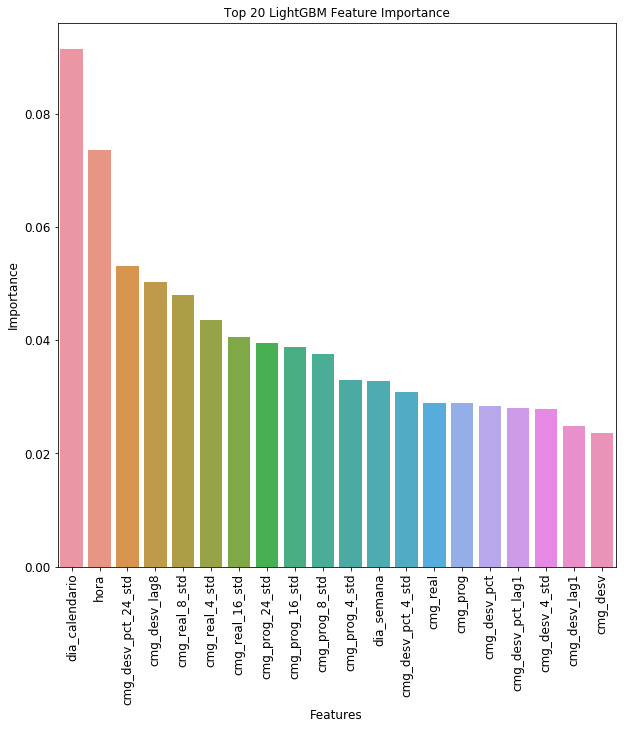

In [64]:
# Predecimos el periodo t7 incluyendo los features de clima
target = 'target_lead7'
test_lead7, new_features = run_simple_lgb(train, validation, test, climate_features, target, params)

Training until validation scores don't improve for 50 rounds.
[100]	training's binary_logloss: 0.38944	valid_1's binary_logloss: 0.254299
[200]	training's binary_logloss: 0.297392	valid_1's binary_logloss: 0.206671
[300]	training's binary_logloss: 0.244091	valid_1's binary_logloss: 0.178953
[400]	training's binary_logloss: 0.209032	valid_1's binary_logloss: 0.164794
[500]	training's binary_logloss: 0.183454	valid_1's binary_logloss: 0.156392
[600]	training's binary_logloss: 0.164231	valid_1's binary_logloss: 0.152066
[700]	training's binary_logloss: 0.14845	valid_1's binary_logloss: 0.149897
[800]	training's binary_logloss: 0.134798	valid_1's binary_logloss: 0.148523
[900]	training's binary_logloss: 0.123198	valid_1's binary_logloss: 0.147162
[1000]	training's binary_logloss: 0.113101	valid_1's binary_logloss: 0.146068
[1100]	training's binary_logloss: 0.104133	valid_1's binary_logloss: 0.145643
[1200]	training's binary_logloss: 0.0963477	valid_1's binary_logloss: 0.145023
[1300]	train

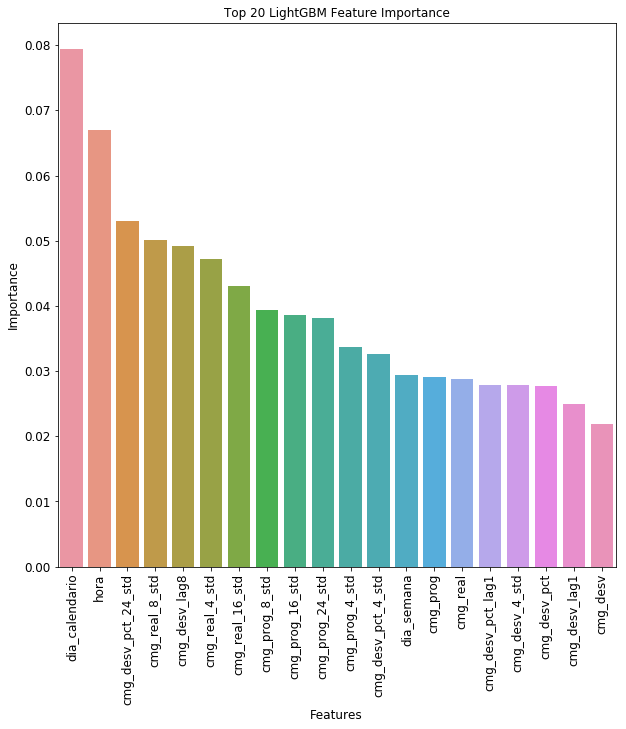

In [65]:
# Predecimos el periodo t8 incluyendo los features de clima
target = 'target_lead8'
test_lead8, new_features = run_simple_lgb(train, validation, test, climate_features, target, params)

Training until validation scores don't improve for 50 rounds.
[100]	training's binary_logloss: 0.388293	valid_1's binary_logloss: 0.254395
[200]	training's binary_logloss: 0.29544	valid_1's binary_logloss: 0.201695
[300]	training's binary_logloss: 0.242193	valid_1's binary_logloss: 0.17319
[400]	training's binary_logloss: 0.208116	valid_1's binary_logloss: 0.157786
[500]	training's binary_logloss: 0.182576	valid_1's binary_logloss: 0.151674
[600]	training's binary_logloss: 0.163192	valid_1's binary_logloss: 0.148081
[700]	training's binary_logloss: 0.147151	valid_1's binary_logloss: 0.14606
Early stopping, best iteration is:
[688]	training's binary_logloss: 0.149028	valid_1's binary_logloss: 0.145938
--------------------------------------------------


Nuestro mejor corte que maximiza el "F1 score" es 0.1181818181818182
Nuestro "F1 score" para la data de validacion es de 0.13468634686346861
Nuestro "F1 score" para la data de prueba es de 0.22885196374622357
----------------------------

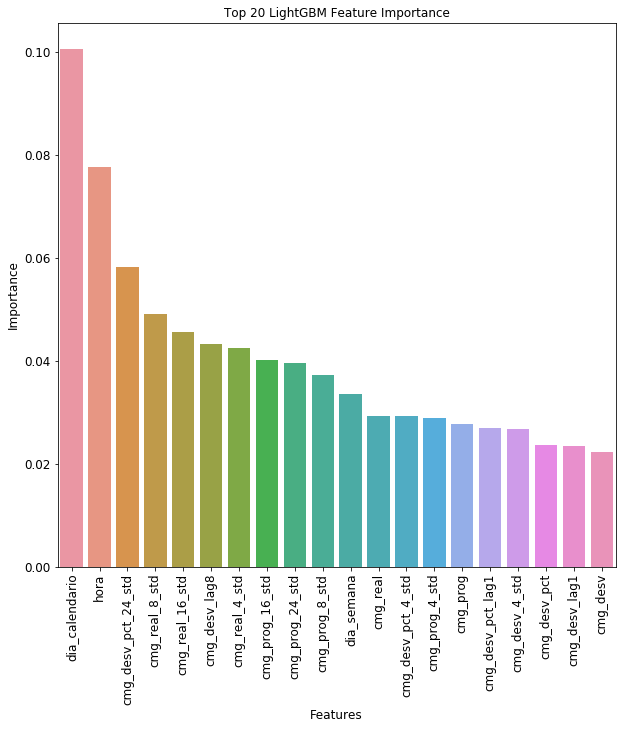

In [66]:
# Predecimos el periodo t9 incluyendo los features de clima
target = 'target_lead9'
test_lead9, new_features = run_simple_lgb(train, validation, test, climate_features, target, params)

Training until validation scores don't improve for 50 rounds.
[100]	training's binary_logloss: 0.390016	valid_1's binary_logloss: 0.252138
[200]	training's binary_logloss: 0.297487	valid_1's binary_logloss: 0.198607
[300]	training's binary_logloss: 0.243769	valid_1's binary_logloss: 0.170134
[400]	training's binary_logloss: 0.208779	valid_1's binary_logloss: 0.158276
[500]	training's binary_logloss: 0.183159	valid_1's binary_logloss: 0.152542
[600]	training's binary_logloss: 0.163187	valid_1's binary_logloss: 0.149687
[700]	training's binary_logloss: 0.14783	valid_1's binary_logloss: 0.146379
[800]	training's binary_logloss: 0.134384	valid_1's binary_logloss: 0.144258
[900]	training's binary_logloss: 0.122801	valid_1's binary_logloss: 0.143033
Early stopping, best iteration is:
[918]	training's binary_logloss: 0.121021	valid_1's binary_logloss: 0.142773
--------------------------------------------------


Nuestro mejor corte que maximiza el "F1 score" es 0.1090909090909091
Nuestro "F1 

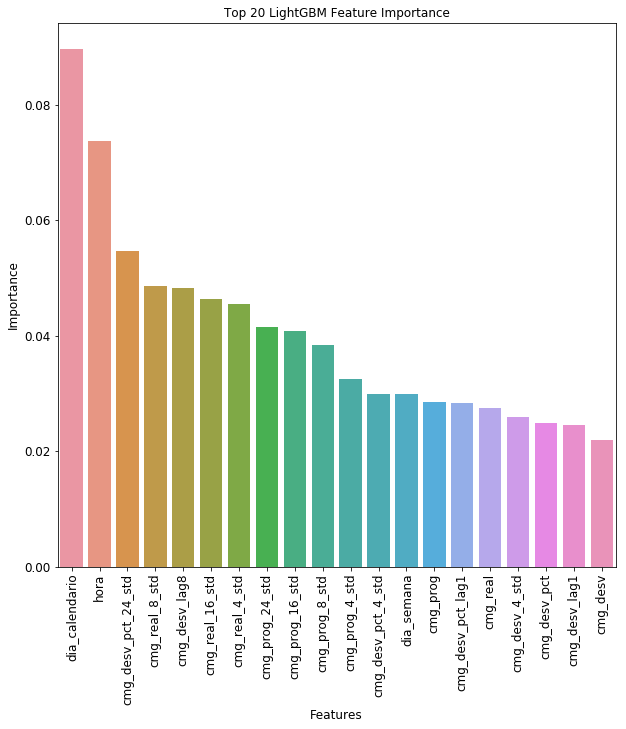

In [67]:
# Predecimos el periodo t10 incluyendo los features de clima
target = 'target_lead10'
test_lead10, new_features = run_simple_lgb(train, validation, test, climate_features, target, params)

Training until validation scores don't improve for 50 rounds.
[100]	training's binary_logloss: 0.392281	valid_1's binary_logloss: 0.254575
[200]	training's binary_logloss: 0.299475	valid_1's binary_logloss: 0.203925
[300]	training's binary_logloss: 0.245673	valid_1's binary_logloss: 0.177071
[400]	training's binary_logloss: 0.210542	valid_1's binary_logloss: 0.163756
[500]	training's binary_logloss: 0.184313	valid_1's binary_logloss: 0.155012
[600]	training's binary_logloss: 0.164546	valid_1's binary_logloss: 0.150115
[700]	training's binary_logloss: 0.148906	valid_1's binary_logloss: 0.147598
[800]	training's binary_logloss: 0.135208	valid_1's binary_logloss: 0.145626
[900]	training's binary_logloss: 0.123567	valid_1's binary_logloss: 0.14456
Early stopping, best iteration is:
[919]	training's binary_logloss: 0.121801	valid_1's binary_logloss: 0.144095
--------------------------------------------------


Nuestro mejor corte que maximiza el "F1 score" es 0.1
Nuestro "F1 score" para la 

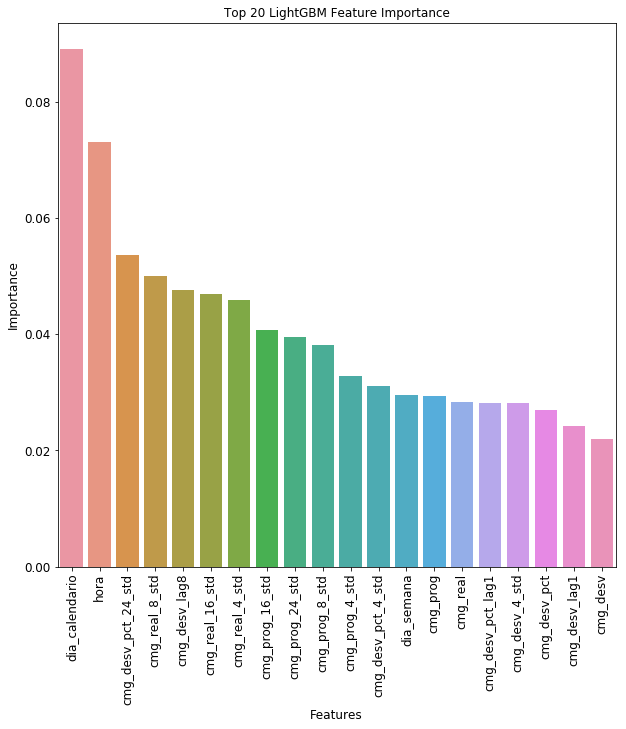

In [68]:
# Predecimos el periodo t11 incluyendo los features de clima
target = 'target_lead11'
test_lead11, new_features = run_simple_lgb(train, validation, test, climate_features, target, params)

Training until validation scores don't improve for 50 rounds.
[100]	training's binary_logloss: 0.393001	valid_1's binary_logloss: 0.252212
[200]	training's binary_logloss: 0.301221	valid_1's binary_logloss: 0.200895
[300]	training's binary_logloss: 0.24839	valid_1's binary_logloss: 0.178343
[400]	training's binary_logloss: 0.213581	valid_1's binary_logloss: 0.162728
[500]	training's binary_logloss: 0.187674	valid_1's binary_logloss: 0.154695
[600]	training's binary_logloss: 0.16754	valid_1's binary_logloss: 0.151376
[700]	training's binary_logloss: 0.151728	valid_1's binary_logloss: 0.14932
[800]	training's binary_logloss: 0.138147	valid_1's binary_logloss: 0.147996
[900]	training's binary_logloss: 0.126574	valid_1's binary_logloss: 0.147412
Early stopping, best iteration is:
[910]	training's binary_logloss: 0.125593	valid_1's binary_logloss: 0.147368
--------------------------------------------------


Nuestro mejor corte que maximiza el "F1 score" es 0.1
Nuestro "F1 score" para la da

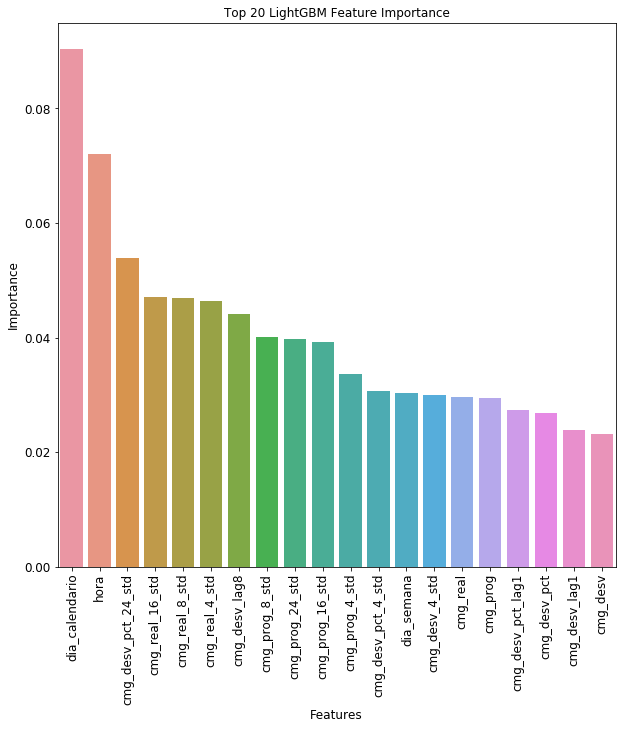

In [69]:
# Predecimos el periodo t12 incluyendo los features de clima
target = 'target_lead12'
test_lead12, new_features = run_simple_lgb(train, validation, test, climate_features, target, params)

In [70]:
f1_score_list = [test_lead1, test_lead2, test_lead3, test_lead4, test_lead5, test_lead6, test_lead7, test_lead8, test_lead9, 
                 test_lead10, test_lead11, test_lead12]
f1_final_score = np.average(f1_score_list)
print(f'Nuestro "F1 score" promedio para los 12 periodos es de {f1_final_score}')

Nuestro "F1 score" promedio para los 12 periodos es de 0.24297165693141964


* Al incluir los features de clima en nuestro modelo la metrica para el set de test bajo de 0.286 a 0.243 "Promedio F1 Score"

* El data leakage se manejo desde antes con la construccion de un set de entrenamiento, validacion y prueba que respetan el orden del tiempo

* La capacidad predictiva del modelo no mejora al incluir los features de clima, esto no significa que no sean utiles, derrepente con otro modelo y realizando ciertos cambios pueden contribuir de forma positiva.

Los mejores features en general fueron (digo en general porque son 12 modelos, por lo tanto las variables mas importante varian)

De todas formas en la mayoria de los modelos, las mas importantes se repiten. 

Algunas de estas variables son:

* dia_calendario
* hora
* cmg_desv_pct_24std: la desviacion estandar movil de los ultimos 24 periodos de la desviacion porcentual del costo
* cmg_real_8_std: la desviacion estandar movil de los ultimos 8 periodos de el costo marginal real




# 8.0 Reflexion

* Es bueno utilizar este tipo de modelos para anticiparse a desvios de precios de energia porque pueden realizar ciertas acciones para optimizar el proceso antes que suceda. Esta informacion predectiva tambien puede servir para otro motivos, incluso encontrar relaciones oculta y comportamientos especiales en la data. Lamentablemente solo entiendo lo basico del problema por lo tanto no podria opinar detalladamente estos aspectos.


* El caso de uso directo que veo con este modelo es que puedes estudiar detalladamente cuando se producen las desviaciones, al entender mejor este comportamiento y como se relaciona con las variables independientes pueden abrir otras oportunidades a la optimizacion de otros procesos dentro de el sistema electrico nacional.